In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 4)

import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [4]:
#Rob: toggle flags
apply_standardization = True
apply_transform = False

## Load and Concatenate

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [7]:
train.shape

(1460, 81)

In [8]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [9]:
test.shape

(1459, 80)

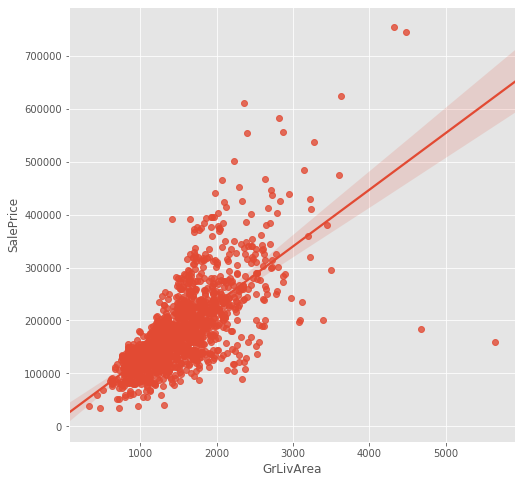

In [10]:
# Very first visual check -- SalePrice ~ GrLivArea
plt.figure(figsize=(8,8))
sns.regplot(x=train.GrLivArea, y=train.SalePrice, data=train)

In [11]:
# remove outliers with GrLivArea > 4_000 sqf
#Rob: revisit these 4 outliers once model pipeline is complete
train = train[train.GrLivArea < 4_000]

In [12]:
# TARGET VARIABLE
SalePrice = train.pop('SalePrice')

In [13]:
df = pd.concat([train, test], axis=0)
df.shape

(2915, 80)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2915.0,1460.7348,843.0458,1.0,731.5,1462.0,2190.50,2919.0
MSSubClass,2915.0,57.1338,42.5467,20.0,20.0,50.0,70.00,190.0
LotFrontage,2429.0,69.1289,22.7154,21.0,59.0,68.0,80.00,313.0
LotArea,2915.0,10133.6487,7806.1985,1300.0,7474.0,9450.0,11554.50,215245.0
OverallQual,2915.0,6.0837,1.4034,1.0,5.0,6.0,7.00,10.0
OverallCond,2915.0,5.5650,1.1137,1.0,5.0,5.0,6.00,9.0
YearBuilt,2915.0,1971.2717,30.2910,1872.0,1953.0,1973.0,2001.00,2010.0
YearRemodAdd,2915.0,1984.2405,20.8973,1950.0,1965.0,1993.0,2004.00,2010.0
MasVnrArea,2892.0,101.3994,177.4529,0.0,0.0,0.0,164.00,1600.0
BsmtFinSF1,2914.0,438.0981,442.8721,0.0,0.0,368.0,732.00,4010.0


## Divide by data type

In [15]:
# drop Id
df.drop(['Id'], axis=1, inplace=True)

In [16]:
cat_features = list(df.select_dtypes(include=['object']).columns)
print(f'Object types:  {len(cat_features)}')
print(cat_features)

Object types:  43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [17]:
num_features = list(df.select_dtypes(include=['int64','float64']).columns)
print(f'Numeric types:  {len(num_features)}')
print(num_features)

Numeric types:  36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [18]:
# Some numeric features are categorical and ordinal, 
# leave the numerical values (potentially intact) but reclassify to categorical
cat_features += ['OverallQual', 'OverallCond']

# Some numeric features are categorical by nature and NOT ordinal: replace with string
df['MSSubClass'] = df.MSSubClass.apply(lambda x: str(x))
df['MoSold'] = df.MoSold.apply(lambda x: str(x))
df['YrSold'] = df.YrSold.apply(lambda x: str(x))

cat_features += ['MSSubClass', 'MoSold', 'YrSold']

print(f'Object types:  {len(cat_features)}')

Object types:  48


In [19]:
# Remove newly classified categoricals from numeric
num_features = [f for f in num_features if f not in cat_features] 
print(f'Numeric types:  {len(num_features)}')

Numeric types:  31


In [20]:
print(cat_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond', 'MSSubClass', 'MoSold', 'YrSold']


In [21]:
print(num_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


## Classify Ordinal vs. Nominal

By default, all categorical features are nominal.  The following are classified ordinal:
- levels are clearly ordered (e.g. Functional, LandSlope, LotShape). This is regardless of the feature's correlation with price, e.g. may be completely uncorrelated. 
- if we __suspect__ order, verify by a boxplot Price~Feature (e.g. 'MSSubClass'). Classify as ordinal only if there is visual correlation with sorted levels

In [22]:
cat_ordinal = [  # definitely ordinal
'Street',
'Alley',
'LotShape',
'Utilities',
'LandSlope',
'ExterQual',
'ExterCond',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'HeatingQC',
'CentralAir',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive',
'PoolQC',
'Fence',    
]
print(f'Definitely ordinal:  {len(cat_ordinal)}')

Definitely ordinal:  23


In [23]:
cat_ordinal_candidates = [ # potentially ordinal
'MSSubClass',
'LandContour',
'LotConfig',
'BldgType',    
'HouseStyle',    
'Foundation',
'Electrical',
'SaleType',
'SaleCondition',
]
print(f'Potentially ordinal:  {len(cat_ordinal_candidates)}')

Potentially ordinal:  9


In [24]:
cat_nominal = [f for f in cat_features if f not in cat_ordinal and f not in cat_ordinal_candidates] 
print(f'Definitely nominal:  {len(cat_nominal)}')
cat_nominal

Definitely nominal:  16


['MSZoning',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',
 'OverallQual',
 'OverallCond',
 'MoSold',
 'YrSold']

In [25]:
# We care about display order for the candidate ordinals:
#Rob: added VWD to SaleType, removed comma after SaleCondition 
display_order = {
'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '160', '180', '190'],
'LandContour': ['Lvl','Bnk', 'HLS', 'Low'],
'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'],
'BldgType':    ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'],
'HouseStyle':  ['1Story', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl'],    
'Foundation': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'],
'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
'SaleType': ['WD','CWD','New','COD','Con','ConLw','ConLI','ConLD','Oth','VWD'],
'SaleCondition': ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
}

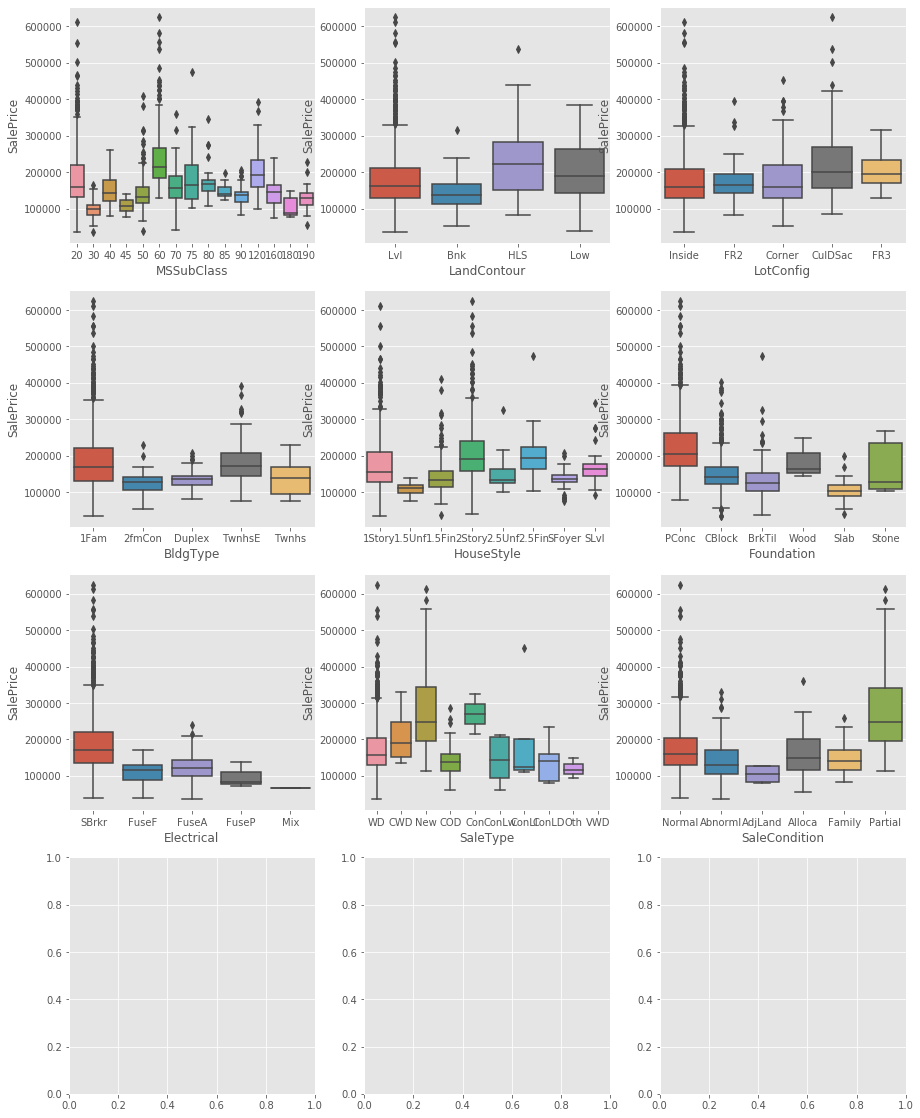

In [26]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(SalePrice),:], SalePrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_ordinal_candidates)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))

counter = 0
for f in cat_ordinal_candidates:
    sns.boxplot(f, 'SalePrice', data=train_processed, order=display_order[f], 
                ax = axes[counter//nc][counter%nc])
    counter+=1

Conclusion: there is no internal order that would cause a visible correlation with the Price. 
All candidate features should be classified as nominal. 

In [27]:
cat_nominal = cat_nominal + cat_ordinal_candidates
cat_nominal = list(set(cat_nominal))
cat_ordinal = list(set(cat_ordinal))

print(f'Nominal features:  {len(cat_nominal)}')
print(f'Ordinal features:  {len(cat_ordinal)}')

Nominal features:  25
Ordinal features:  23


## Neighborhoods

In [28]:
display_order = train_processed.groupby(['Neighborhood']).mean()['SalePrice']
display_order = display_order.sort_values(ascending=False).index.to_list()

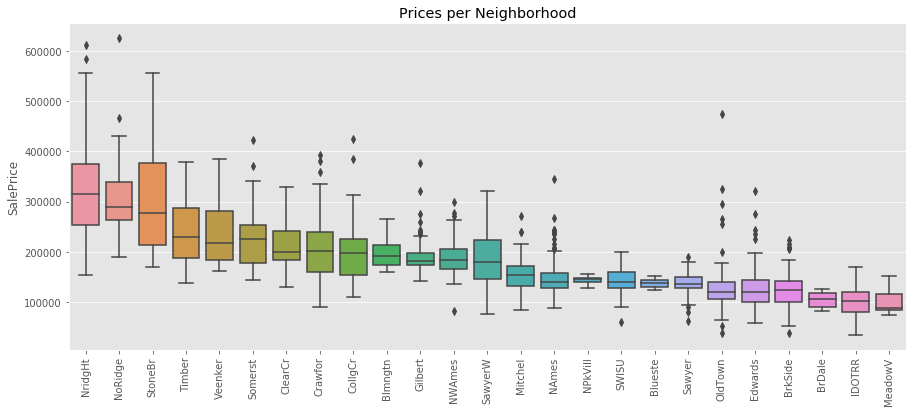

In [29]:
plt.figure(figsize=(15,6))
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=train_processed, order=display_order)
plt.xticks(rotation=90)
plt.title('Prices per Neighborhood')
plt.xlabel('')
plt.show()

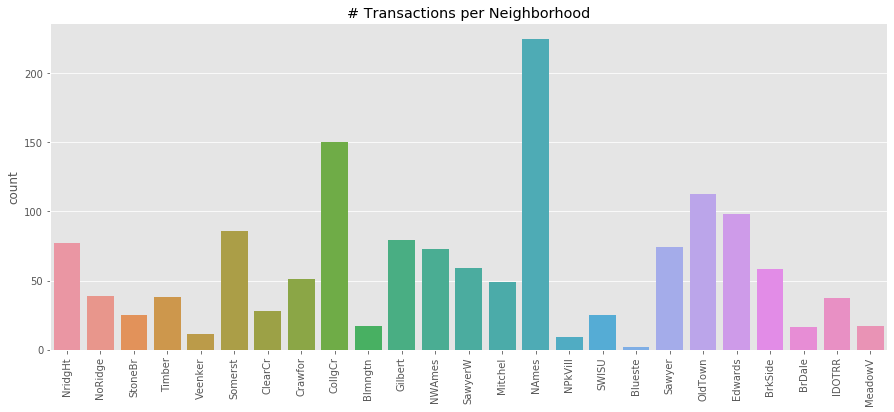

In [30]:
plt.figure(figsize=(15,6))
sns.countplot("Neighborhood", data=train_processed, order=display_order)
plt.xticks(rotation=90)
plt.title('# Transactions per Neighborhood')
plt.xlabel('')
plt.show()

Nominal categorical will only be dummified, ordinals remain intact (possibly rescaling)

## Categorical features: Impute nan

Verify each categorical feature to apply the following approach:
- nominal features: replace nan with string 'None' unless has specific meaning
- ordinal features: replace nan with 0 unless nan means something else. Nan typically means the absence of the feature such as 'no garage'.  Later, map the remaining levels to 1,2,..

In [31]:
for f in cat_nominal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

2810   nans in   MiscFeature
1   nans in   Exterior2nd
24   nans in   MasVnrType
1   nans in   SaleType
4   nans in   MSZoning
1   nans in   Electrical
157   nans in   GarageType
1   nans in   Exterior1st


In [32]:
for f in cat_ordinal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

159   nans in   GarageFinish
2   nans in   Functional
79   nans in   BsmtFinType1
80   nans in   BsmtFinType2
82   nans in   BsmtExposure
2717   nans in   Alley
1420   nans in   FireplaceQu
159   nans in   GarageCond
1   nans in   KitchenQual
82   nans in   BsmtCond
2   nans in   Utilities
159   nans in   GarageQual
2907   nans in   PoolQC
2345   nans in   Fence
81   nans in   BsmtQual


Checked all missing columns, the default approach of replacing with 'None' and 0 should work

In [33]:
for f in cat_nominal:
    df[f].fillna('None', inplace=True)

In [34]:
for f in cat_ordinal:
    df[f].fillna(0, inplace=True)

## Map Ordinal to numeric

In [35]:
# NB map the FULL dictionary from the description b/c some labels may appear only in the test set
# still, check unique levels for all ordinals in the train set
{f: list(train[f].unique()) for f in cat_ordinal}

{'GarageFinish': ['RFn', 'Unf', 'Fin', nan],
 'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'Functional': ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av', nan],
 'CentralAir': ['Y', 'N'],
 'PavedDrive': ['Y', 'N', 'P'],
 'Alley': [nan, 'Grvl', 'Pave'],
 'FireplaceQu': [nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'BsmtCond': ['TA', 'Gd', nan, 'Fa', 'Po'],
 'Utilities': ['AllPub', 'NoSeWa'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'GarageQual': ['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'],
 'PoolQC': [nan, 'Ex', 'Fa', 'Gd'],
 'Fence': [nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'],
 'Street': ['Pave', 'Grvl'],
 'BsmtQual': ['Gd', 'TA', 'Ex', nan, 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],

In [36]:
# Mapping convention: higher levels ~ higher price (NOT always applicable, e.g. LotShape)
# arbitrary convention for the sake of interpretation consistency, should not affect any ML
ordinal_to_numeric = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley': {'Grvl':1, 'Pave':2},
    'LotShape': {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4},
    'Utilities': {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
    'LandSlope': {'Gtl':1, 'Mod':2, 'Sev':3}, #Rob: order reversed? shouldn't affect anything but the interpretation
    'Fence':{'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}, #Rob: added per Sam's analysis

    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'BsmtQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtExposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'BsmtFinType1': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'BsmtFinType2': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},

    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'CentralAir': {'N':0, 'Y':1},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    # bigger step for 'Typical' - #Rob: why use a larger step between Min1 and Typ?
    'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':10},  
    'FireplaceQu': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'GarageFinish': {'Unf':1, 'RFn':2, 'Fin':3},
    'GarageQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'PavedDrive': {'N':1, 'P':2, 'Y':3},
    'PoolQC': {'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
}

In [37]:
for f in ordinal_to_numeric:
    df[f].replace(ordinal_to_numeric[f], inplace=True)

In [38]:
# verify 
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2,0,1,Lvl,4,Inside,...,0,0,0,0,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,2,0,1,Lvl,4,FR2,...,0,0,0,0,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,2,0,2,Lvl,4,Inside,...,0,0,0,0,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,2,0,2,Lvl,4,Corner,...,0,0,0,0,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,2,0,2,Lvl,4,FR2,...,0,0,0,0,None,0,12,2008,WD,Normal


## Adding new Boolean features

In [39]:
# Booleans
df['_Basement'] = df.TotalBsmtSF>0
df['_Garage'] = df.GarageArea>0
df['_Pool'] = df.PoolArea>0
df['_Fence'] = df.Fence!=0  #Rob: Fence is now an ordinal so check for 0 instead of None
# combine 4 types of porches
df['_Porch'] = df.OpenPorchSF+df.EnclosedPorch+df['3SsnPorch']+df.ScreenPorch > 0

#Rob:added
df['_MasVnrArea'] = (df.MasVnrType != 'None')
df['_WoodDeck'] = df.WoodDeckSF > 0
df['_MiscFeature'] = (df.MiscFeature!='None')

In [40]:
# More Booleans
#Rob: revisit the bucketing on YearBuilt if there's time
df['_New'] = df.YearBuilt > 2000  #potentially bucketize the entire range
df['_Old'] = df.YearBuilt < 1920 

df['_Remodeled'] = df.YearRemodAdd != df.YearBuilt
df['_NormalSale'] = df.SaleCondition=='Normal'
df['_AfterWW2'] = (df.YearBuilt >= 1946) #Rob: added per Sam's analysis

In [41]:
#Rob: all the boolean features created thus far
new_boolean = ['_Basement', 
               '_Garage', 
               '_Pool', 
               '_Fence', 
               '_Porch',
               '_MasVnrArea',
               '_WoodDeck', 
               '_MiscFeature',
               '_New',
               '_Old', 
               '_Remodeled', 
               '_NormalSale',
               '_AfterWW2']

In [42]:
# convert to int
for f in new_boolean:
    df[f]=df[f].astype(np.int64)

## Clustering: Categorical

In [43]:
# (optionally add TSNE / UMAP)

In [44]:
all_categorical = cat_nominal + cat_ordinal + new_boolean

In [45]:
chisq_table = np.zeros((len(all_categorical), len(all_categorical)))

for i, f1 in enumerate(all_categorical):
    for j, f2 in enumerate(all_categorical):
        tab = pd.crosstab(df[f1], df[f2])
        chisq_table[i,j] = scipy.stats.chi2_contingency(tab)[1]

sort_order = np.argsort(chisq_table.sum(axis=0))
chisq_table = chisq_table[:,sort_order]
chisq_table = chisq_table[sort_order,:]
heatmap_labels = [all_categorical[i] for i in sort_order]

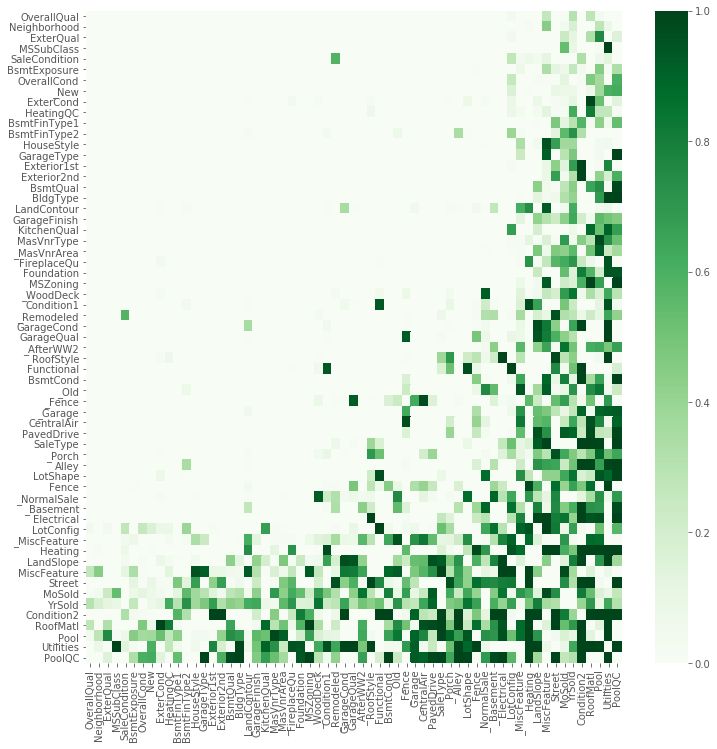

In [46]:
plt.figure(figsize=(12,12))
sns.heatmap(chisq_table, cmap="Greens", xticklabels=heatmap_labels, yticklabels=heatmap_labels)

- The core group of ~10-15 defining characteristics at the top, highly influential (ExterQual, OverallQual, MSSubClass, Neighborhood, New, etc)
- A few categories at the bottom seem to be randomly spread -> candidates for removal

In [47]:
n_tail = 15  #candidates to be removed with n as HP
removal_candidates_0 = heatmap_labels[-n_tail:]
removal_candidates_0

['_Basement',
 'Electrical',
 'LotConfig',
 '_MiscFeature',
 'Heating',
 'LandSlope',
 'MiscFeature',
 'Street',
 'MoSold',
 'YrSold',
 'Condition2',
 'RoofMatl',
 '_Pool',
 'Utilities',
 'PoolQC']

## ANOVA

Verify the clustering intuition with ANOVA LogPrice~Category 

In [48]:
# ANOVA requires that the reponse variables be ~ normal. Log transform the SalePrice.

In [49]:
LogPrice=np.log(SalePrice).rename('LogPrice')

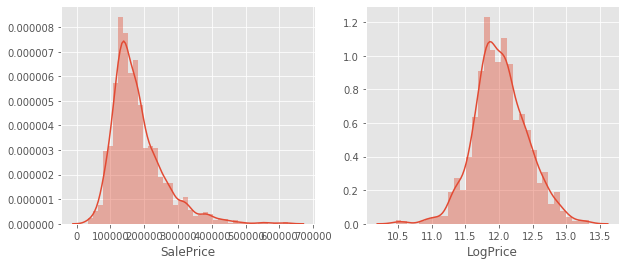

In [50]:
f,axes = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(SalePrice, ax=axes[0])
sns.distplot(LogPrice, ax=axes[1])

Text(0.5, 1.0, 'After log transform')

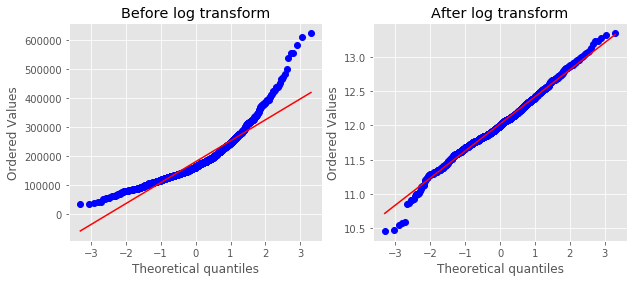

In [51]:
#Rob: put the before and after Q-Q plots side by side for better visuals.
f,axes = plt.subplots(1, 2, figsize=(10, 4))
res1 = stats.probplot(SalePrice, plot=axes[0])
axes[0].set_title("Before log transform")
res2 = stats.probplot(LogPrice, plot=axes[1])
axes[1].set_title("After log transform")

In [52]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

In [53]:
train_processed.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,_Porch,_MasVnrArea,_WoodDeck,_MiscFeature,_New,_Old,_Remodeled,_NormalSale,_AfterWW2,LogPrice
0,60,RL,65.0,8450,2,0,1,Lvl,4,Inside,...,1,1,0,0,1,0,0,1,1,12.2477
1,20,RL,80.0,9600,2,0,1,Lvl,4,FR2,...,0,0,1,0,0,0,0,1,1,12.1090


In [54]:
# ANOVA F-statistic with its p-value
F_values, p_values = {},{}

for f in all_categorical:
    group_prices = []
    for group in train_processed[f].unique():
        group_prices.append(train_processed[train_processed[f]==group]['LogPrice'].values)

    F_values[f], p_values[f] = scipy.stats.f_oneway(*group_prices)

In [55]:
F_values = {k:v for k,v in sorted(F_values.items(), key=lambda x: x[1])}
p_values = {k:v for k,v in sorted(p_values.items(), key=lambda x: x[1])}

In [56]:
p_values

{'OverallQual': 0.0,
 'Neighborhood': 7.451511247758564e-242,
 'ExterQual': 5.487175661842523e-196,
 'BsmtQual': 2.3173557817592845e-187,
 'KitchenQual': 5.292077079765444e-186,
 'GarageFinish': 2.7129993153636604e-151,
 'GarageType': 3.8754404716470255e-126,
 'MSSubClass': 1.3207872601320131e-114,
 'FireplaceQu': 1.259783529169019e-113,
 'Foundation': 1.4239979430131833e-111,
 '_New': 1.9683225274080212e-87,
 'HeatingQC': 2.058334264452287e-82,
 'BsmtFinType1': 3.1174290570333098e-77,
 'MasVnrType': 3.061545957996824e-67,
 'MSZoning': 2.8287104898669344e-60,
 'Exterior1st': 3.1629861258661e-56,
 '_MasVnrArea': 1.991342016079393e-54,
 'OverallCond': 5.422658470876797e-54,
 'Exterior2nd': 5.062412545054888e-50,
 'GarageCond': 8.378096673084188e-48,
 '_AfterWW2': 1.1217261332133207e-46,
 'BsmtExposure': 1.864979140868811e-46,
 'GarageQual': 2.0672588008711154e-46,
 'CentralAir': 3.7176103148526634e-44,
 'SaleCondition': 4.115462010677253e-44,
 'SaleType': 1.6088300269571204e-37,
 '_Porch


Possible candiates to remove with p-value >0.05: #Rob: changed p-value threshold to 0.05
- '_Pool'
- 'PoolQC'
- 'LandSlope'
- 'MoSold'
- 'YrSold'
- 'Utilities'

## Classify and Visualize

In [57]:
len(all_categorical)

61

In [58]:
#Rob: added the 3 new boolean features
cat_qual = [
 'OverallQual', 
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',  # mainly shed
 
 'Foundation',
 'Electrical',
 'Fence',
 'Utilities',
 
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',

 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 '_Basement',
 '_Garage',
 '_Pool',
 '_Fence',
 '_Porch',
 '_MasVnrArea',
 '_WoodDeck',
 '_AfterWW2',
 '_MiscFeature'
]

In [59]:
len(cat_qual)

38

In [60]:
# [x for x in all_categorical if x not in elements]

In [61]:
cat_location = [
'MSZoning',
'Neighborhood',
'Condition1',
'Condition2',
]
                
cat_sale = [            
'SaleType',
'SaleCondition',
'_NormalSale',
'MoSold',
'YrSold',
]
    
cat_type = [
'MSSubClass',
'BldgType',
'HouseStyle',
'Functional',
'_Remodeled',
'_Old',
'_New',
]

cat_land = [    
'LotShape',
'LandSlope',
'LandContour',
'LotConfig',
'Street',
'Alley',
'PavedDrive',
]

In [62]:
# verify completeness
assert set(all_categorical)==set(cat_qual+cat_location+cat_sale+cat_type+cat_land)
assert len(all_categorical)==len(cat_qual+cat_location+cat_sale+cat_type+cat_land)


In [63]:
def plot_counts(cat_group, col_wrap=4):
    f = pd.melt(df, value_vars=cat_group)
    g = sns.FacetGrid(f, col='variable', col_wrap=col_wrap, sharex=False, sharey=False)
    g = g.map(sns.countplot, 'value')
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.fig.tight_layout()
    plt.show()    

In [64]:
#Rob : disabling the plots of histograms for now as they don't add much information at this point
show_hist = True

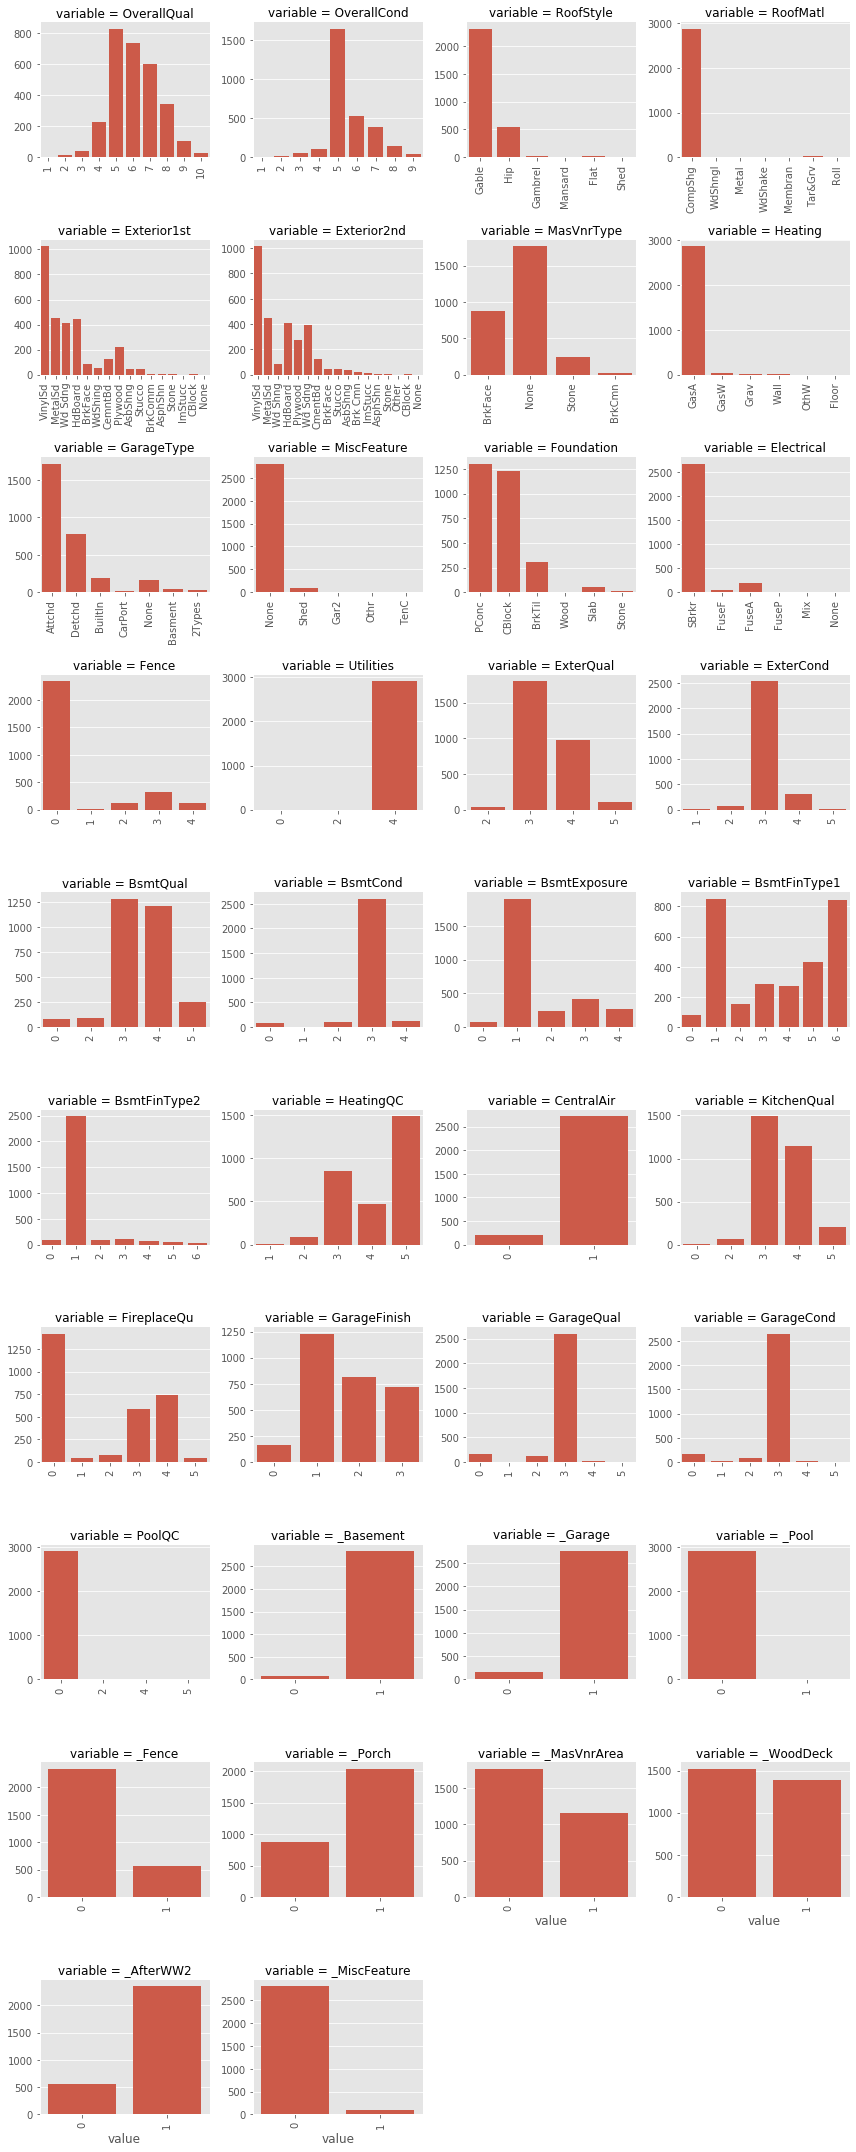

In [65]:
if show_hist:
    plot_counts(cat_qual)

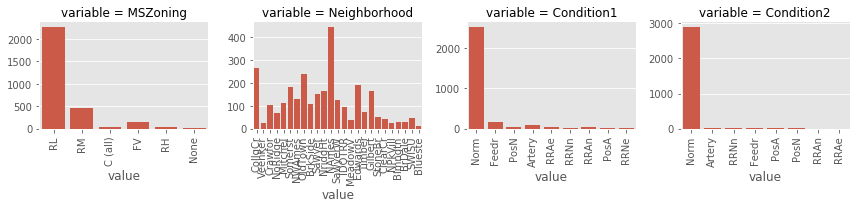

In [66]:
if show_hist:
    plot_counts(cat_location)

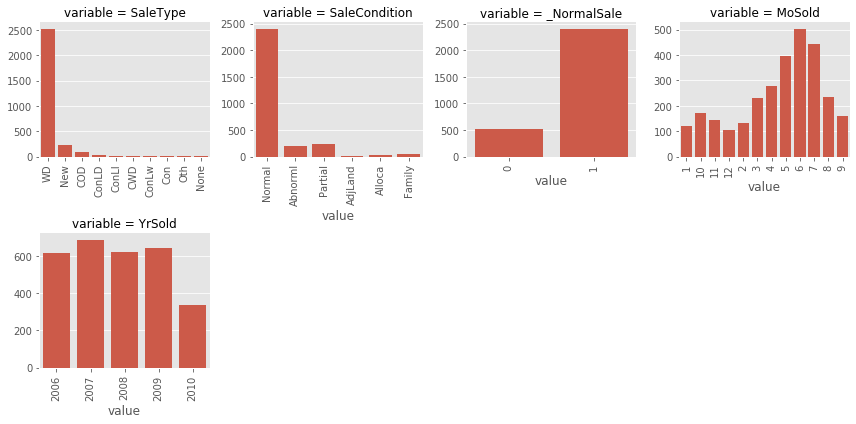

In [67]:
if show_hist:
    plot_counts(cat_sale)

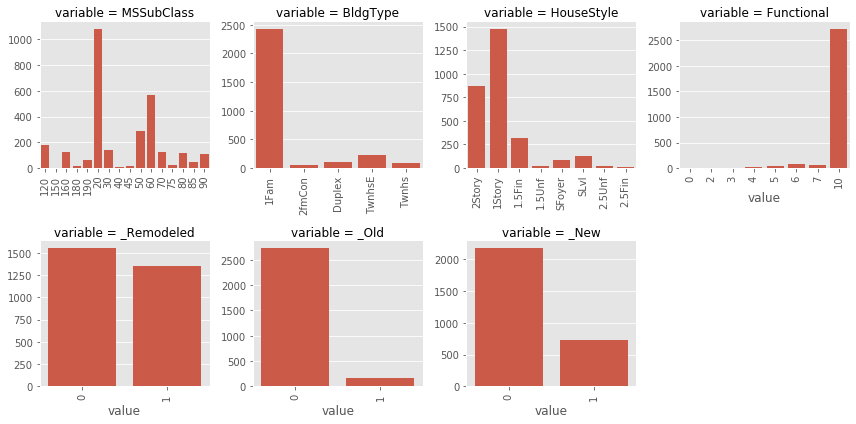

In [68]:
if show_hist:
    plot_counts(cat_type)

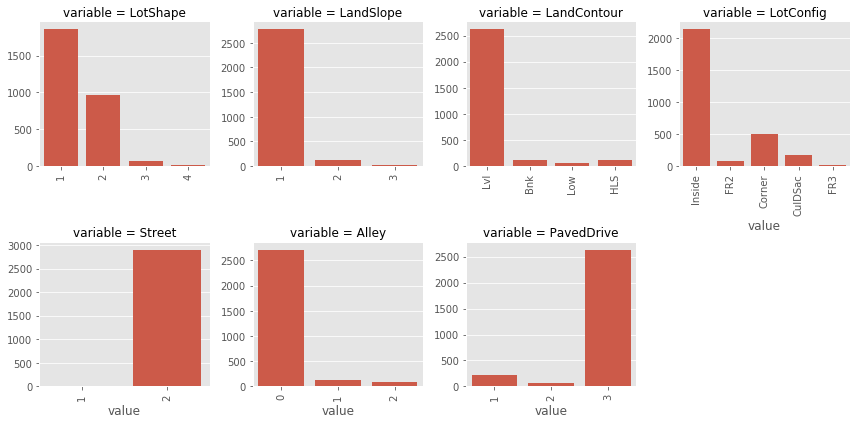

In [69]:
if show_hist:
    plot_counts(cat_land)

## Influential features

In [70]:
#Select least p-value features on the F-test. Visualize Boxplots (Price or LogPrice?)

In [71]:
cat_influential = [
# from cat_location
'Neighborhood',
'MSZoning',
# from the cat_sale
'SaleCondition',
'SaleType',    
# from cat_type
'MSSubClass',
'_Old',
'_New',    
# zero from the cat_land
# from cat_qual
'OverallQual', 
'OverallCond',
'KitchenQual',
'FireplaceQu',
'Foundation',
'HeatingQC',
'CentralAir',    
'MasVnrType',
'_Porch',  
    
'Exterior1st',
'Exterior2nd',
'ExterQual',   
    
'GarageFinish',
'GarageType',
'GarageQual',    
'GarageCond',
'_Garage',    
    
'BsmtQual',
'BsmtExposure',    
'BsmtFinType1',    
]
print(f'Inflential features:  {len(cat_influential)}')


Inflential features:  27


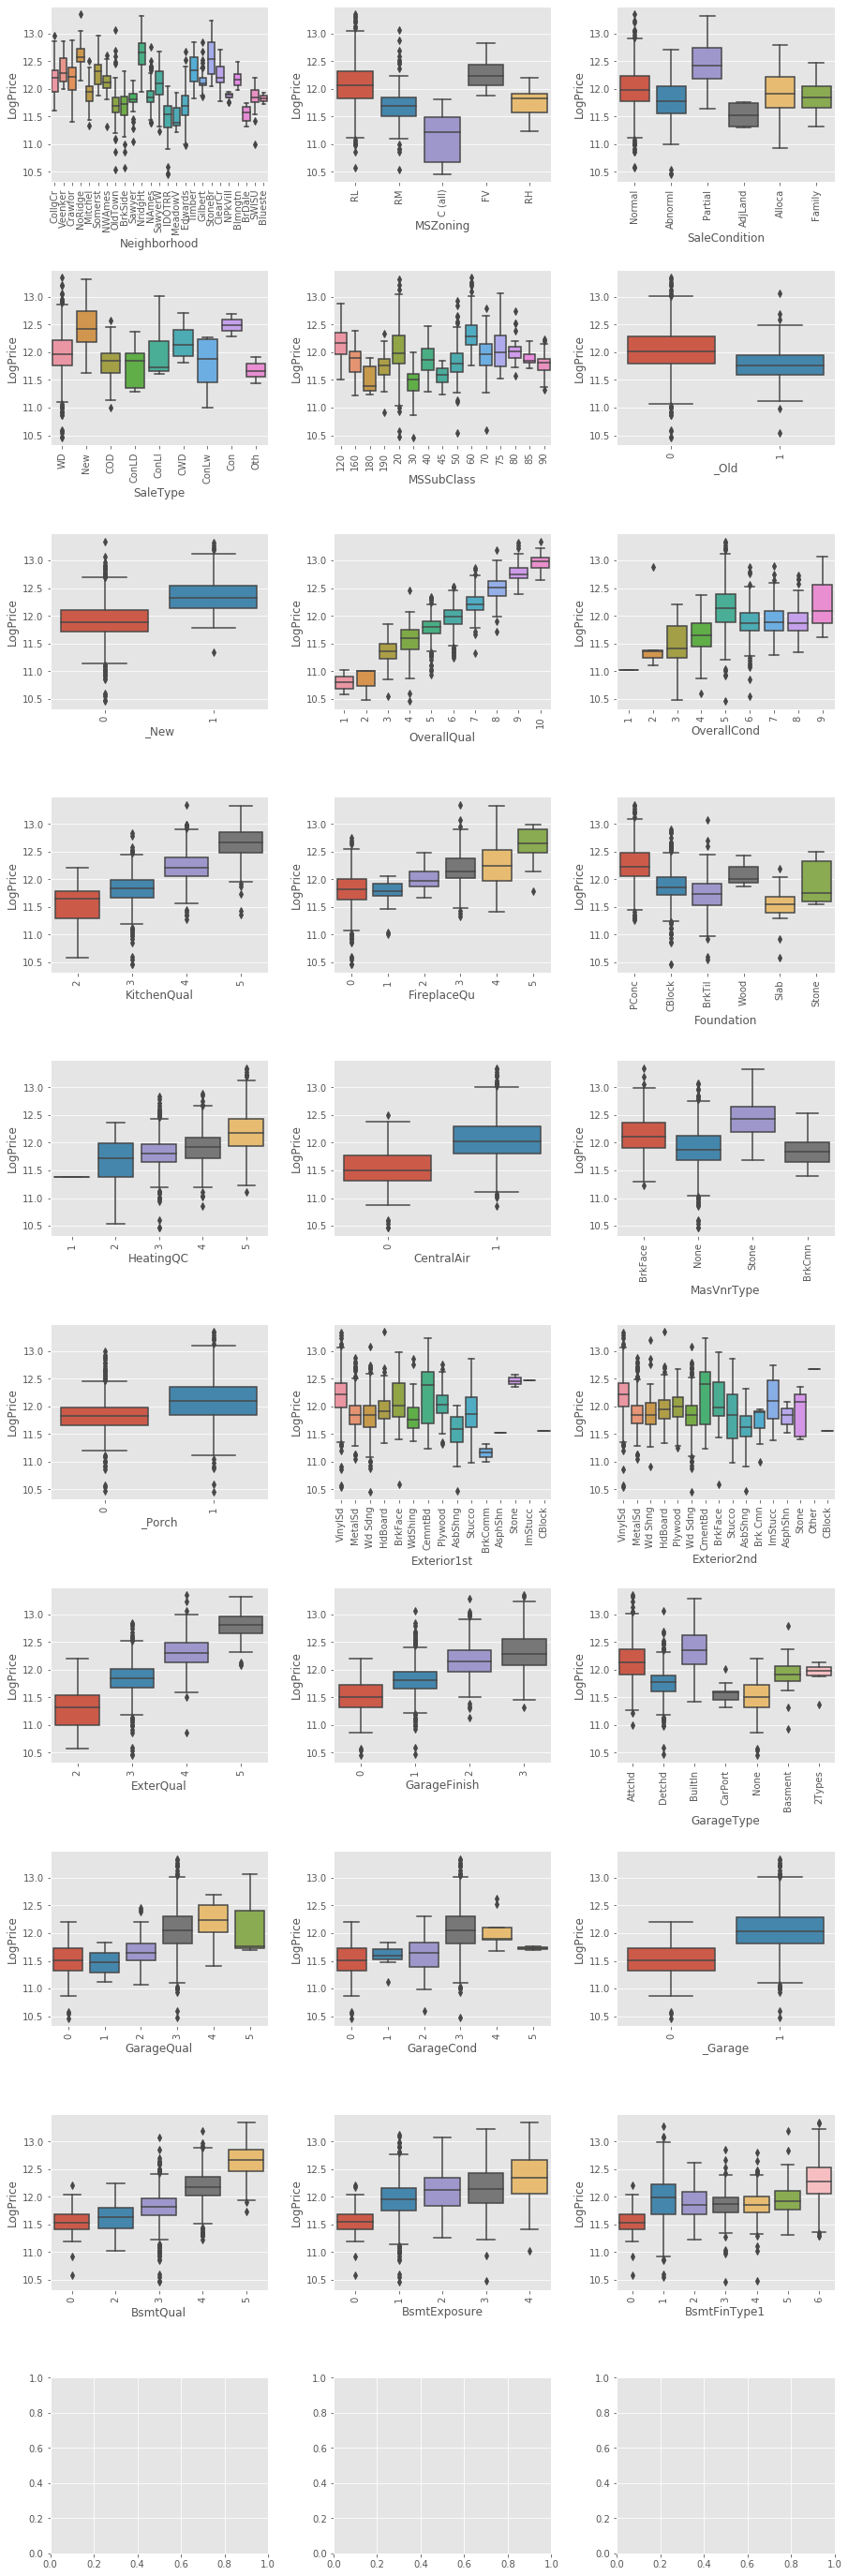

In [72]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_influential)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))
f.subplots_adjust(hspace=.5, wspace=.3,)

counter = 0
for f in cat_influential:
    ax = sns.boxplot(f, 'LogPrice', data=train_processed, ax = axes[counter//nc][counter%nc])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    counter+=1


# NUMERICAL

In [73]:
# divide into 3 groups
len(num_features)

31

In [74]:
num_continous = [
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'GarageArea',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
]

num_count = [
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageCars',      
]

num_buckets = [
'YearBuilt',
'YearRemodAdd',
'GarageYrBlt',
]


In [75]:
len(num_continous) + len(num_buckets) + len(num_count)

31

In [76]:
df[num_continous].shape

(2915, 19)

In [77]:
df[num_continous].isnull().sum(axis=0)

LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

## Impute missing values

In [78]:
#Rob:
#impute missing values using KNN -- use all features in training set impute missing values for LotFrontage & MasVnr

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= round(np.sqrt(train[num_continous].shape[0])))

imputer.fit(train['LotFrontage'][:,np.newaxis])
df['LotFrontage'] = imputer.transform(df['LotFrontage'][:,np.newaxis])

imputer.fit(train['MasVnrArea'][:,np.newaxis])
df['MasVnrArea'] = imputer.transform(df['MasVnrArea'][:,np.newaxis])


In [79]:
# sum(df.isnull().sum(axis=0))
for f in df.columns:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

1   nans in   BsmtFinSF1
1   nans in   BsmtFinSF2
1   nans in   BsmtUnfSF
1   nans in   TotalBsmtSF
2   nans in   BsmtFullBath
2   nans in   BsmtHalfBath
159   nans in   GarageYrBlt
1   nans in   GarageCars
1   nans in   GarageArea


In [80]:
# Explore GarageYrBlt
df[df.GarageYrBlt.isna() & df._Garage==1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,_Fence,_Porch,_MasVnrArea,_WoodDeck,_MiscFeature,_New,_Old,_Remodeled,_NormalSale,_AfterWW2
666,60,RM,57.0,8094,2,1,1,Lvl,4,Inside,...,1,1,0,1,1,0,1,1,1,0


In [81]:
# replace all with zeros
for f in df.columns:
    df[f].fillna(0, inplace=True)                

In [82]:
#Rob: making the merge easier by creating the df train
train = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

## Numerical features: Correlations & transformations

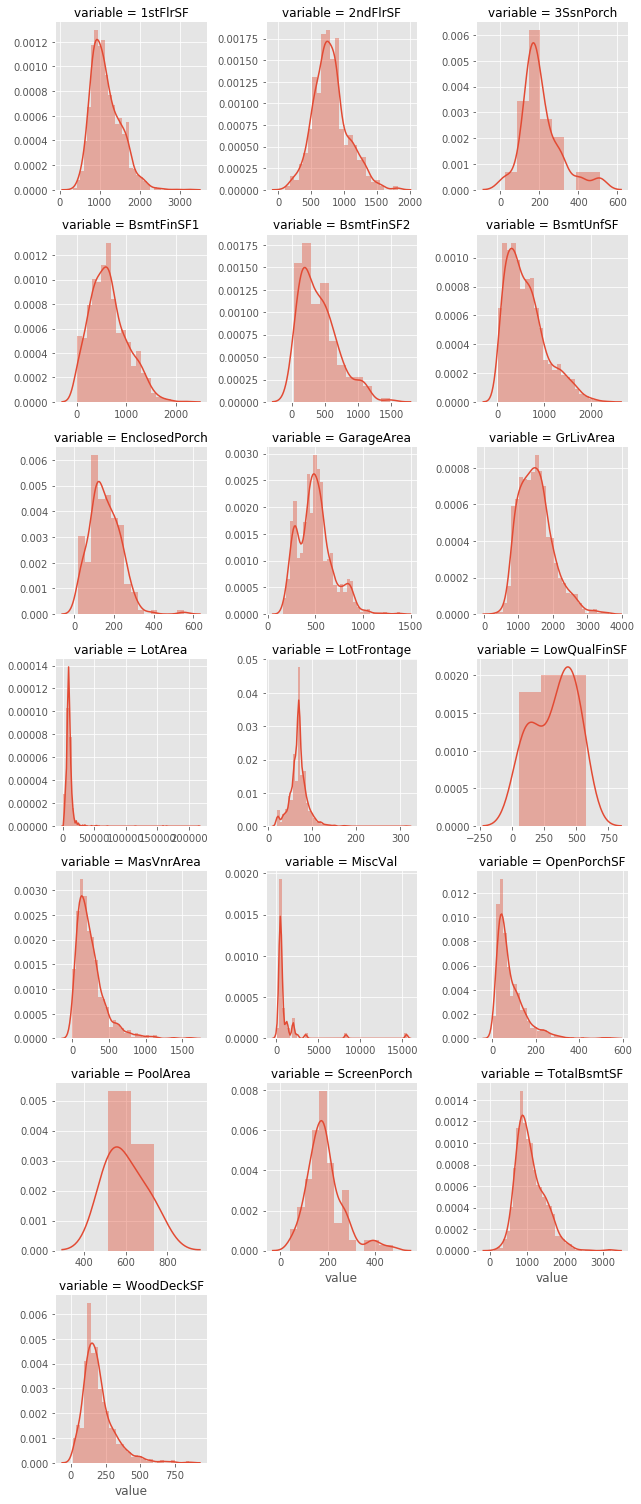

In [83]:
#density plots of original numerica features
f = pd.melt(train[num_continous][train[num_continous]>0], value_vars=sorted(num_continous))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

pretty much every numerical feature exhibits right skewness - these are good candidates for log transformation

In [84]:
##transform all numerical values
train_transformed = train[num_continous].copy()

for f in num_continous:
    train_transformed.loc[:,f] = np.log1p(train[f])

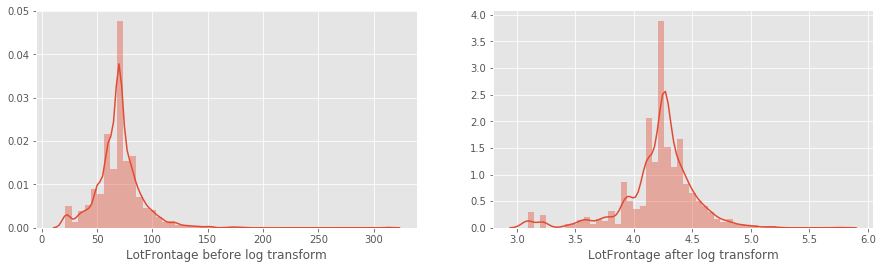

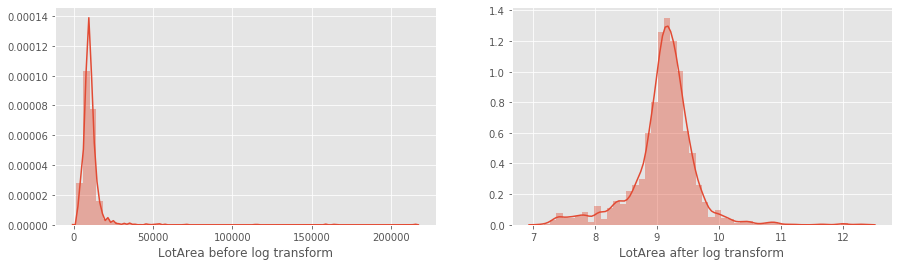

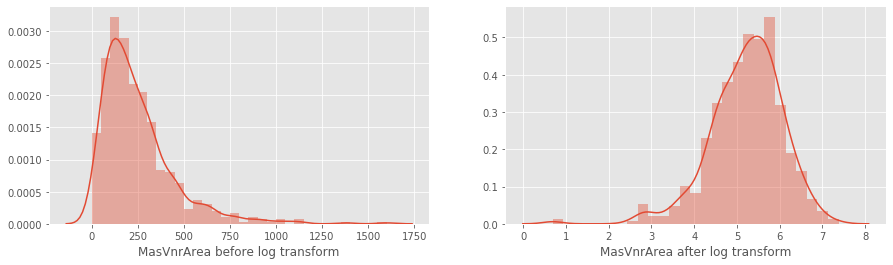

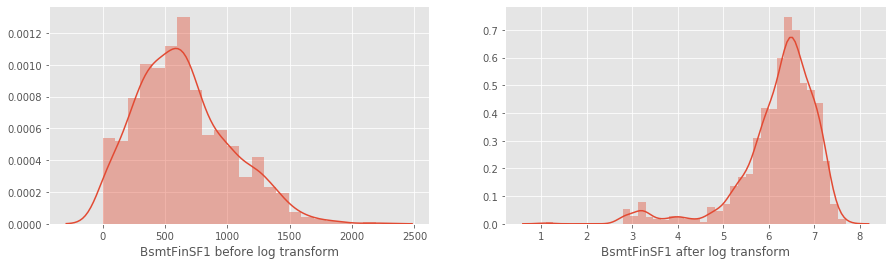

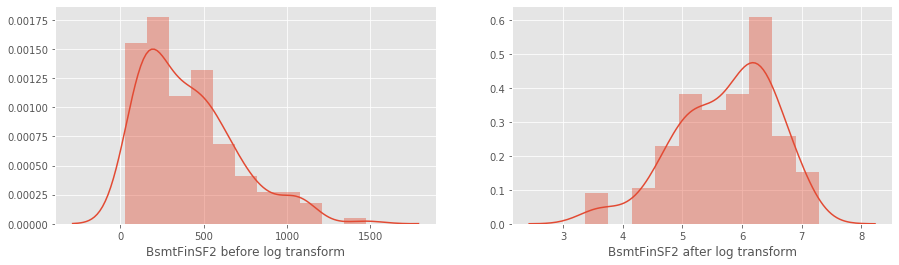

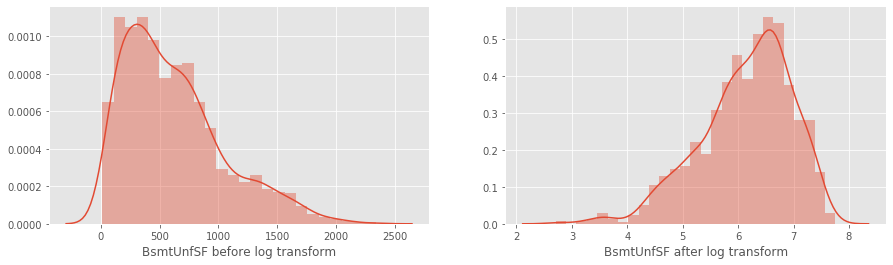

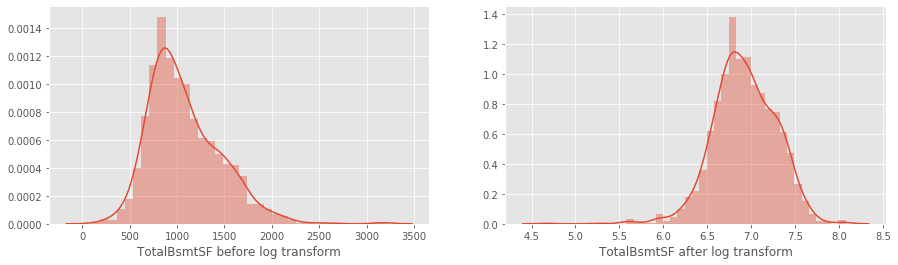

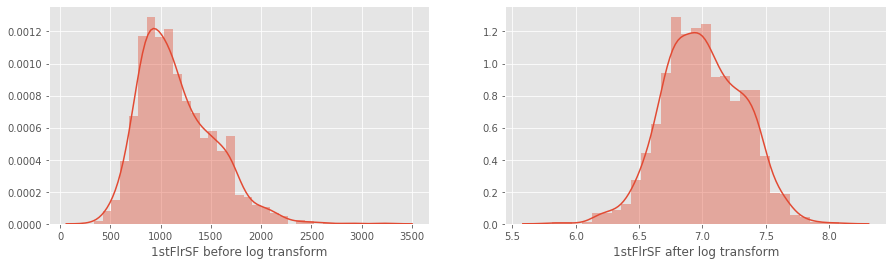

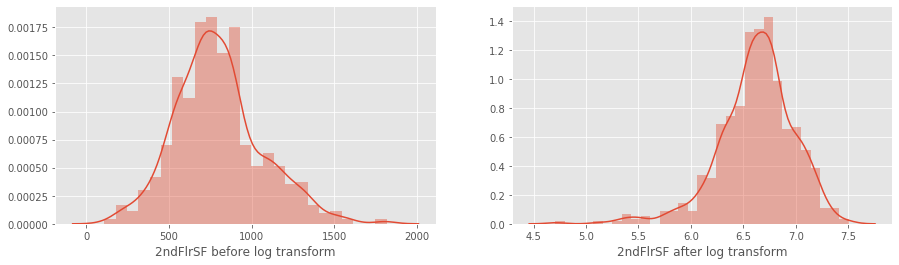

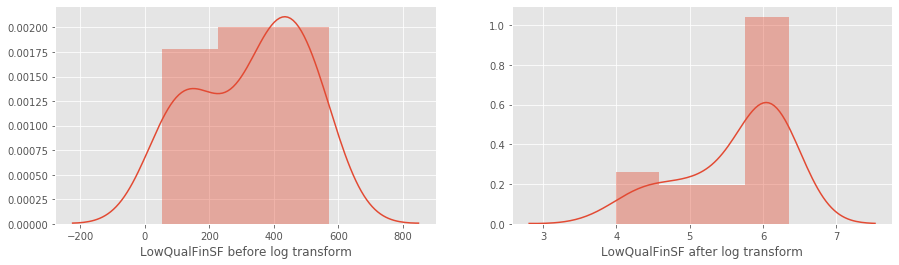

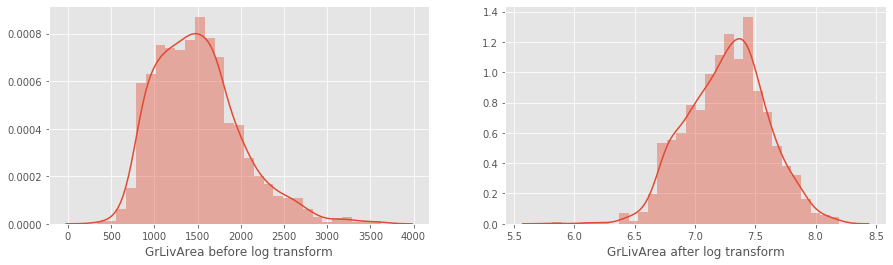

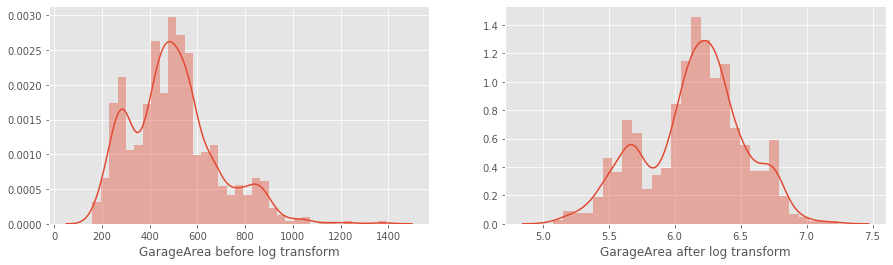

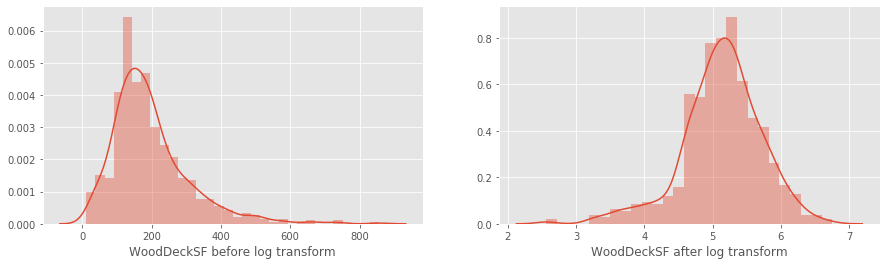

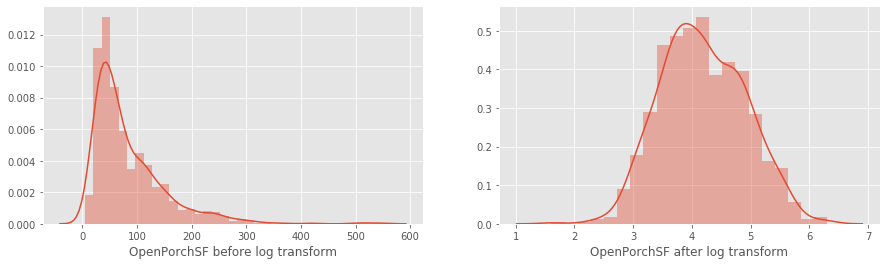

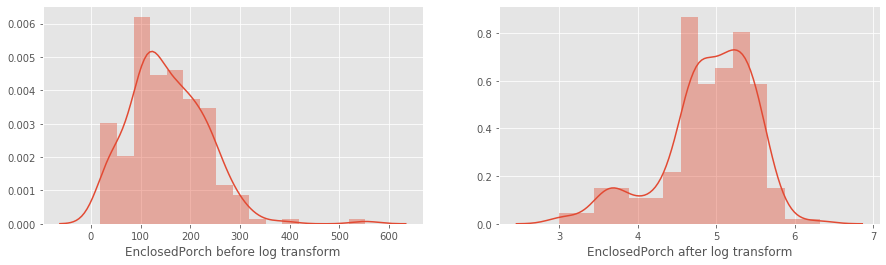

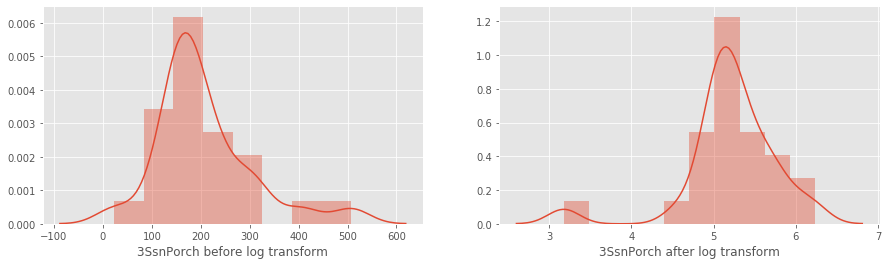

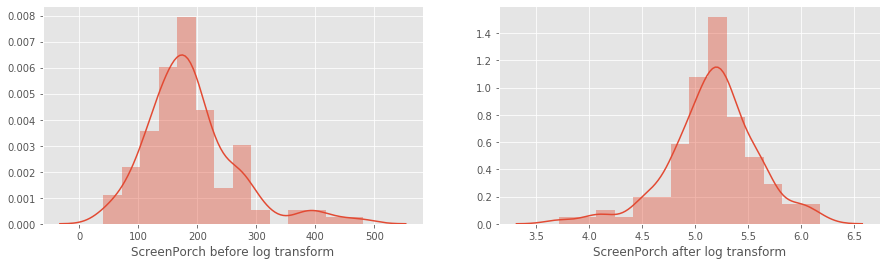

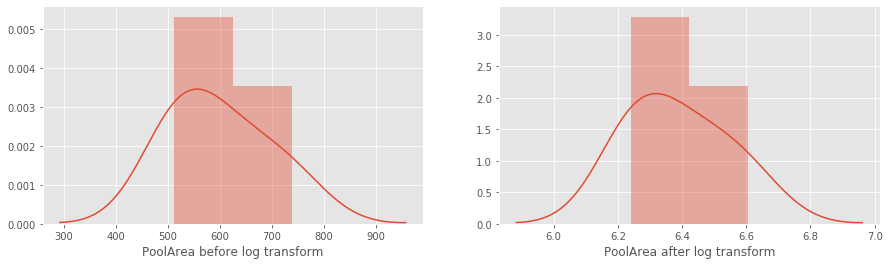

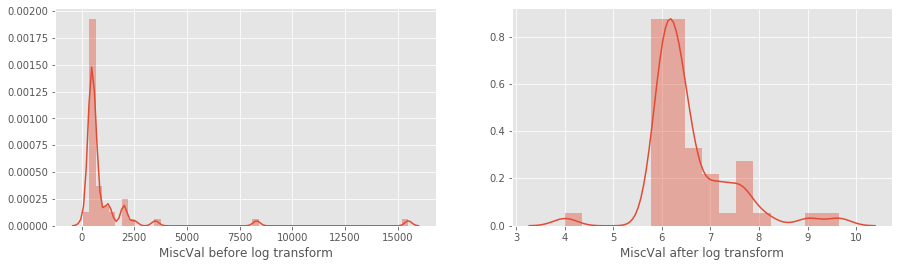

In [85]:
##plot before and after charts
for f in num_continous:
    fig,axes = plt.subplots(1, 2, figsize=(15, 4))
    g = sns.distplot(train[f][train[f] != 0], ax=axes[0])
    g.set(xlabel =f"{f} before log transform")
    g = sns.distplot(train_transformed[f][train_transformed[f] != 0], ax=axes[1])
    g.set(xlabel =f"{f} after log transform")


numerical features are closer to the normal curve post transformation

In [86]:

train_transformed.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

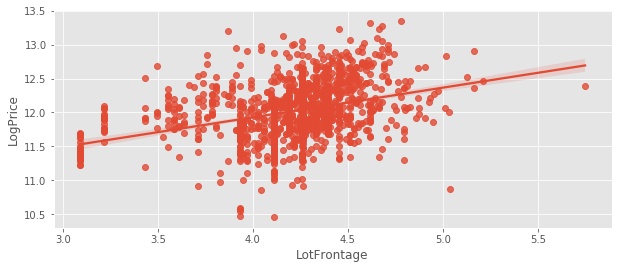

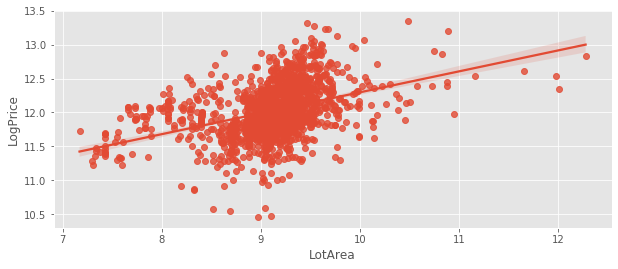

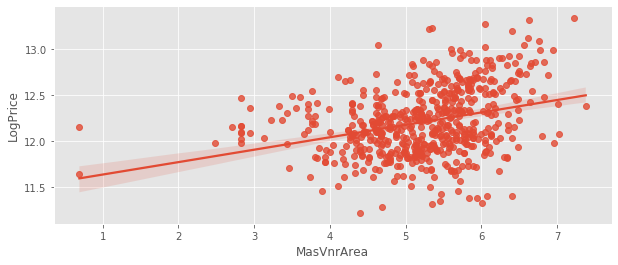

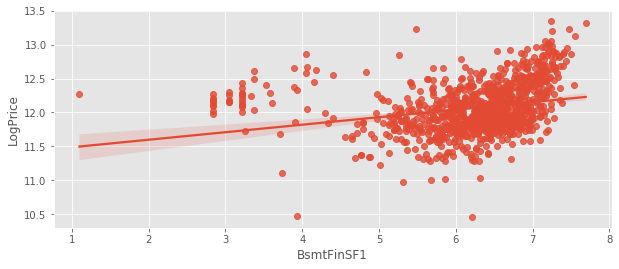

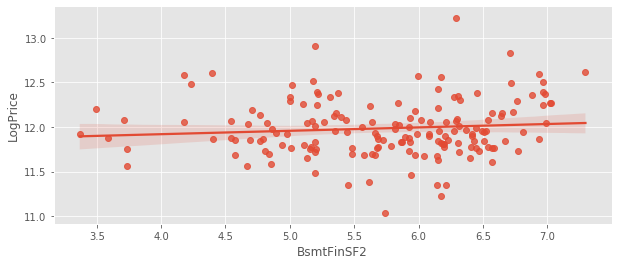

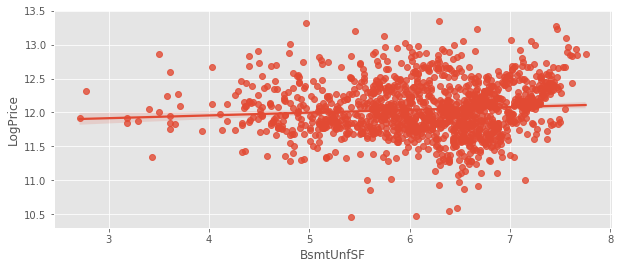

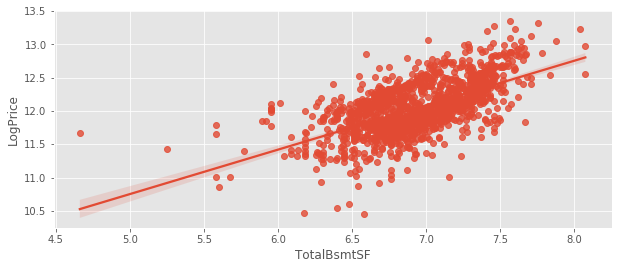

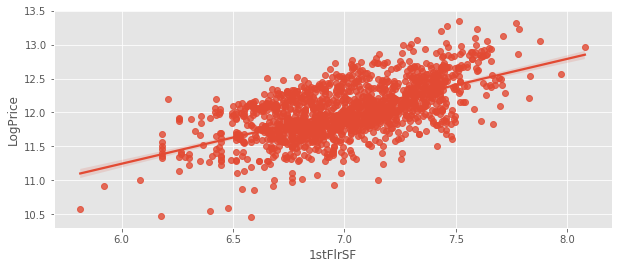

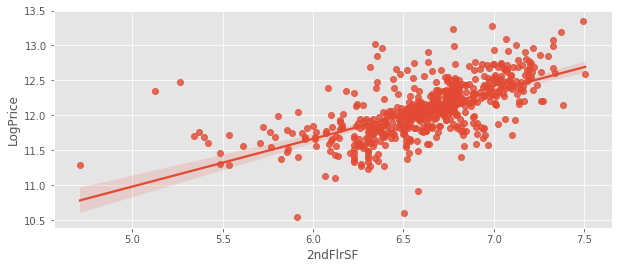

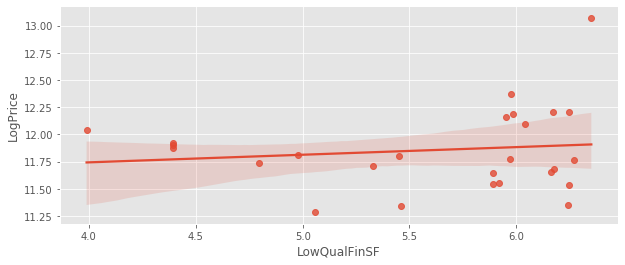

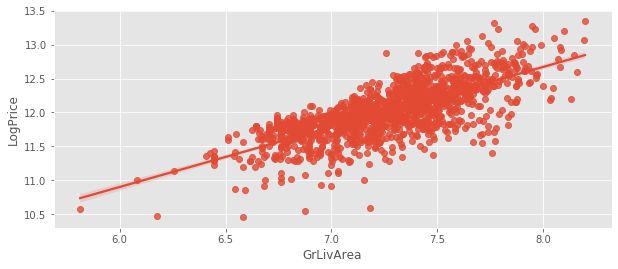

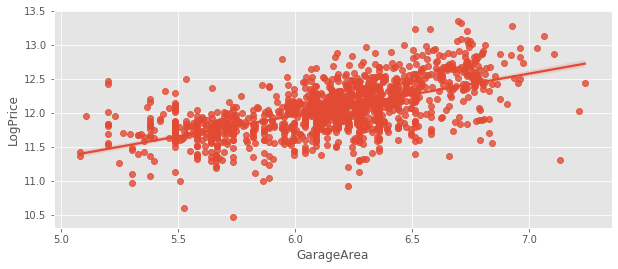

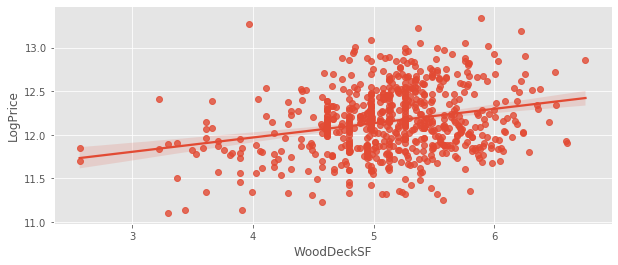

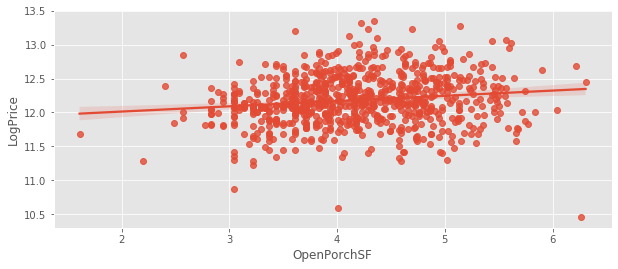

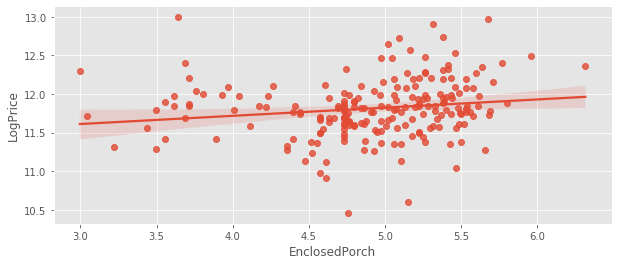

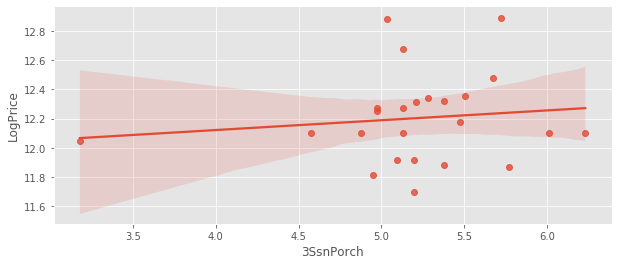

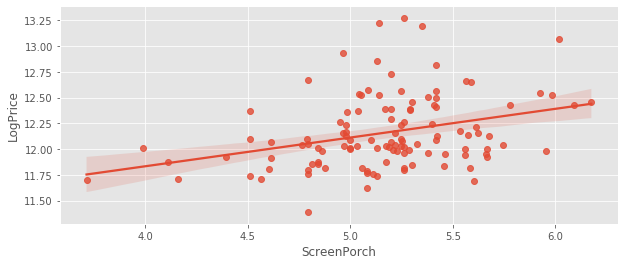

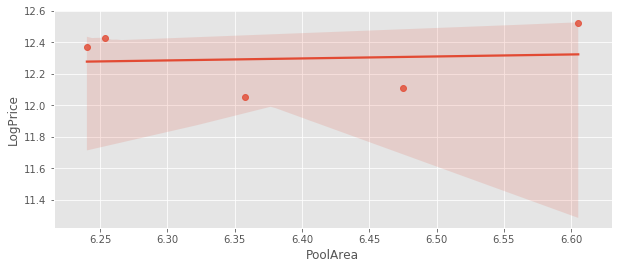

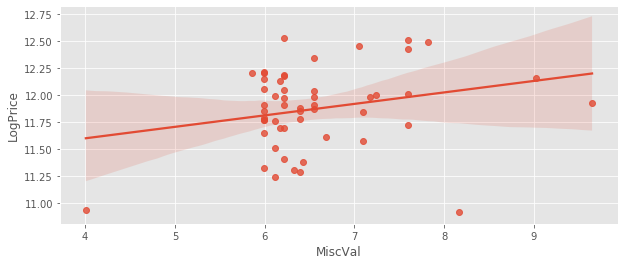

In [87]:
##scatter plot of saleprice vs the log transformed predictors
#num_continous = num_continous.remove('LogPrice')

for f in num_continous:
    fig,axes = plt.subplots(1, 1, figsize=(10, 4))
    g = sns.regplot(train_transformed[f][train_transformed[f]!=0], train['LogPrice'][train_transformed[f]!=0])
    

BsmtFinSF1 might fit better with quadratic.
Strongest linear relationships:
    LotFrontage, LotArea, MasVnrArea,TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea, WoodDeckSF

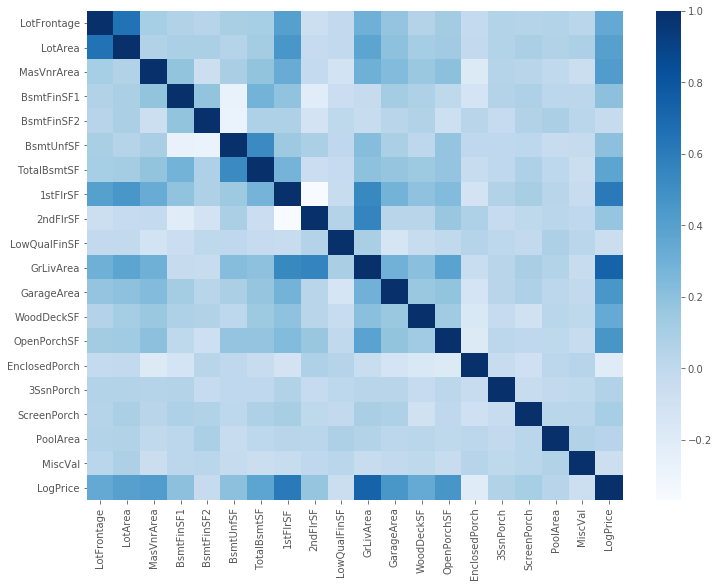

In [88]:
#another way is to look at their correlation to LogPrice
train_transformed['LogPrice'] = train['LogPrice']
corMatrix = train_transformed.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corMatrix, cmap="Blues")

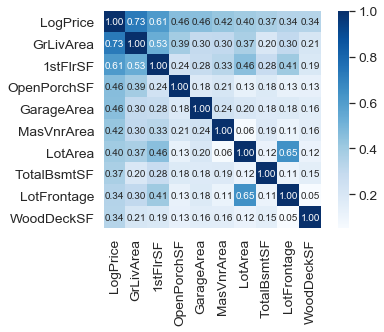

In [89]:
##hone in on top k most correlated
k = 10 #number of variables for heatmap
cols = corMatrix.nlargest(k, 'LogPrice')['LogPrice'].index
cm = np.corrcoef(train_transformed[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

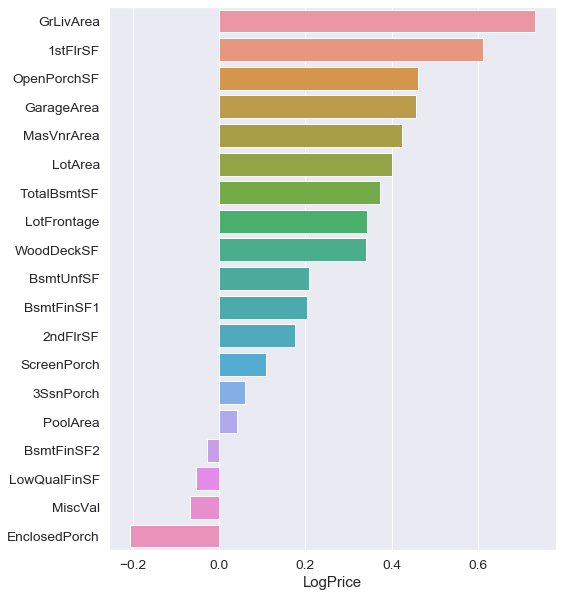

In [90]:
#another view of correlation to saleprice
corr = corMatrix.sort_values('LogPrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.LogPrice[1:], corr.index[1:], orient='h')
plt.show()

In [91]:
list(corMatrix.columns)

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'LogPrice']

In [92]:
if apply_transform:
    for f in num_continous:
        df.loc[:,f] = np.log1p(df[f])

## Standardize

In [93]:
# standardize LogPrice, save the scaler for the inverse transform
if apply_standardization:
    logprice_scaler = StandardScaler().fit(LogPrice[:,np.newaxis])
    Y = logprice_scaler.transform(LogPrice[:,np.newaxis])

In [94]:
# standardize numerical predictors. fit on train, transorm both train and test
if apply_standardization:
    for f in num_continous:
        scaler = StandardScaler().fit(df[f][:len(LogPrice), np.newaxis])
        df[f] = scaler.transform(df[f][:,np.newaxis])

## Feature Generation

In [95]:
##adding some numerical features that are usually looked at together

df['TotalSF'] = df.TotalBsmtSF + df.GrLivArea
df['TotalFloorSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch

In [96]:
num_continous += ['TotalSF','TotalFloorSF','TotalPorchSF']

# Features Checkpoint

In [97]:
df_dummified = pd.get_dummies(df, drop_first=True)

# X = df_dummified
X_train = df_dummified.iloc[:len(Y), :]
X_test  = df_dummified.iloc[len(Y):, :]

df_dummified.shape, X_train.shape, X_test.shape, Y.shape 

((2915, 248), (1456, 248), (1459, 248), (1456, 1))

In [98]:
import time
df_dummified.to_csv(f'data/features_{round(time.time())}.csv', index=False)


# ============ MODEL ============

## Select cross validation K

In [99]:
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import sklearn.model_selection as ms


In [100]:
lasso = linear_model.Lasso(alpha=0.001) 
lasso.fit(X_train, Y) 

r2 = lasso.score(X_train, Y)
beta0 = lasso.intercept_

betas = pd.Series(lasso.coef_, index=X_train.columns)
betas = betas.sort_values(axis=0, ascending=False)  #Rob: showing all betas not just the positive ones

print(r2)
print(beta0)
print(betas)

0.9338820054403544
[-16.36703661]
Neighborhood_Crawfor    0.2908
SaleType_New            0.2685
MSZoning_FV             0.2253
MSZoning_RL             0.2109
Neighborhood_StoneBr    0.1913
                         ...  
Neighborhood_IDOTRR    -0.0722
MSSubClass_30          -0.0727
KitchenAbvGr           -0.0971
MSSubClass_160         -0.1608
Neighborhood_MeadowV   -0.1611
Length: 248, dtype: float64


In [101]:
lasso = linear_model.Lasso(alpha=0.001) 
scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=10)

print('Scores: {}'.format(scores))
print('Score mean: {}'.format(scores.mean()))
print('Score std deviation: {}'.format(scores.std()))

Scores: [0.8899828  0.93825642 0.93294855 0.91028758 0.90752591 0.91867756
 0.90672575 0.93799407 0.92781257 0.91112717]
Score mean: 0.918133839494548
Score std deviation: 0.015028661354810685


In [102]:
r2_mean = []
r2_se = []
 
kfold = range(5,40,5)    
for i in kfold:
    print(f'Evaluating kfold={i}')
    scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=i)
    r2_mean.append(scores.mean())
    r2_se.append(scores.std())

Evaluating kfold=5
Evaluating kfold=10
Evaluating kfold=15
Evaluating kfold=20
Evaluating kfold=25
Evaluating kfold=30
Evaluating kfold=35


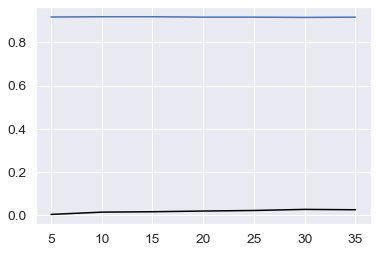

In [103]:
plt.plot(kfold, r2_mean)
plt.plot(kfold, r2_se, color='black')
plt.show()

In [104]:
# CONCLUSION: 
# K=5  is enough, no need for more

## Feature Selection

In [105]:
# VIF check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = df_dummified.columns
vif["VIF"] = [variance_inflation_factor(df_dummified.iloc[:len(LogPrice),:].values, i) for i in range(df_dummified.shape[1])]

vif[vif.VIF <5].sort_values(by=['VIF'], ascending=False)

,features,VIF
121,Neighborhood_Timber,4.8428
225,MoSold_5,4.7316
102,Neighborhood_ClearCr,4.6351
196,Foundation_Slab,4.6065
116,Neighborhood_SWISU,4.5901
...,...,...
241,SaleType_Oth,1.2371
97,LotConfig_FR3,1.2360
235,SaleType_Con,1.1965
129,Condition1_RRNe,1.1914


In [106]:
# mutual information -- a potential filter to select features
# for any 2 rand.vars: KL Divergence between joint PDF and product of marginal PDFs ('information gain')

from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train, Y)
mi /= np.max(mi)

mi = pd.Series(mi, index=X_train.columns)
mi = mi.sort_values(axis=0, ascending=False)

In [107]:
subset = None

In [108]:
# Option A.  leave only influential
if subset=='influential':

#     df_subset =  df[list(mi[:120].index)]
#     df_dummified = pd.get_dummies(df_subset, drop_first=True)

    df_dummified = df_dummified[list(mi[:200].index)]

    X_train = df_dummified.iloc[:len(Y), :]
    X_test  = df_dummified.iloc[len(Y):, :]


In [109]:
# group features by type, to be fed into the permutations below
feature_groups = {
    'area':    ['TotalSF','TotalFloorSF','TotalPorchSF','GrLivArea','1stFlrSF','2ndFlrSF','LowQualFinSF',],
                'other_continuous': ['LotFrontage','LotArea','MasVnrArea','PoolArea','MiscVal',],
    'counts':  ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                'TotRmsAbvGrd','Fireplaces','GarageCars',],
    'age':     ['YearBuilt','YearRemodAdd','GarageYrBlt',],
    'quality': ['OverallQual','KitchenQual','OverallCond','Exterior1st','Exterior2nd','ExterQual','ExterCond',
                 'MasVnrType', '_MasVnrArea','RoofStyle','RoofMatl',],
    'basement':['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtQual','BsmtCond',
                'BsmtExposure','BsmtFinType1','BsmtFinType2','_Basement',],
    'garage':  ['GarageFinish','GarageQual','GarageCond','GarageType','_Garage',],
    'porch':   ['_Porch','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',],
    'other':   ['GarageArea','WoodDeckSF','Foundation','Electrical','Fence','_Fence','Utilities',
                'Heating','HeatingQC','CentralAir','FireplaceQu','PoolQC','_Pool','_WoodDeck',
                'MiscFeature','_MiscFeature',],
    'location':['MSZoning','Neighborhood','Condition1','Condition2',],
    'sale':    ['SaleType','SaleCondition','_NormalSale','MoSold','YrSold',],
    'house_type': ['MSSubClass','BldgType','HouseStyle','Functional','_Remodeled','_Old','_New','_AfterWW2',],
    'land':    ['LotShape','LandSlope','LandContour','LotConfig','Street','Alley','PavedDrive',],
}

## Grid Search: Helper Functions

In [110]:
def prices_from_normalized(normalized):
    return np.exp(logprice_scaler.inverse_transform(normalized)).round()

In [111]:
def rmsle(y_true, y_hat):
    return np.sqrt(np.mean((np.log(y_true)-np.log(y_hat))**2))

In [112]:
def mae(y_true, y_hat):
    return np.mean(np.abs(y_true-y_hat))

In [113]:
def mape(y_true, y_hat):
    return np.mean(np.abs(y_true-y_hat)/y_true)

In [114]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return mean_squared_error(logprice_scaler.inverse_transform(y_true), 
                              logprice_scaler.inverse_transform(y_pred), 
                              squared=False)

In [115]:
def predict_prices(model, x):
    y_hat = model.predict(x)
    y_hat = logprice_scaler.inverse_transform(y_hat)
    y_hat = np.exp(y_hat).round()
    return y_hat

In [116]:
def visualize_HP(df, HP_xlabel, HP_xvalues):
    f,axes = plt.subplots(1, 2, figsize=(16, 4))
    ax0,ax1=axes[0],axes[1]

    ax0.plot(df.r2_train, label='R2 train full') 
    ax0.plot(df.r2_CV_mean, label='R2 CV mean') 
    ax0.fill_between(range(len(HP_xvalues)), df.r2_CV_mean-2*df.r2_CV_se, df.r2_CV_mean+2*df.r2_CV_se, color='lightgrey')
    ax0.set_xticks(range(len(HP_xvalues)))
    ax0.set_xticklabels(HP_xvalues)
    ax0.set_title('R2:   train vs. cross-validated')
    ax0.set_xlabel(HP_xlabel)
    ax0.legend()

    ax1.plot(df.rmse_train, label='RMSE train full') 
    ax1.plot(df.rmse_CV_mean, label='RMSE CV mean') 
    ax1.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    ax1.set_xticks(range(len(HP_xvalues)))    
    ax1.set_xticklabels(HP_xvalues)
    ax1.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax1.set_xlabel(HP_xlabel)
    ax1.legend()

    plt.show()


In [117]:
def visualize_residuals(SalePrice, train_predictions):
    emp_error = train_predictions - SalePrice

    f,axes = plt.subplots(2, 2, figsize=(12, 12))
    ax0,ax1,ax2,ax3=axes[0,0],axes[0,1],axes[1,0],axes[1,1]

    ax0.scatter(train_predictions,SalePrice, marker='.')
    ax0.plot( (min(SalePrice), max(SalePrice)), (min(SalePrice), max(SalePrice)),color='k')
    ax0.set_title('Train set: actual vs predicted')
    ax0.set_xlabel('predicted price')

    ax1.scatter(train_predictions, emp_error, marker='.')
    ax1.axhline(0, color='k')
    ax1.set_title('Train set: residuals')
    ax1.set_xlabel('predicted price')

    ax2.scatter(train_predictions, emp_error/SalePrice, marker='.')
    ax2.axhline(0, color='k')
    ax2.set_title('% empirical error')
    ax2.set_xlabel('predicted price')

    ax3.hist(emp_error/SalePrice,bins=40)
    ax3.set_title(f'% empirical error. std={np.std(emp_error/SalePrice):.4f}')
    ax3.set_xlabel('% error')

    plt.show()

In [118]:
def visualize_groups(df, HP_xlabel, HP_xvalues, hline):
    f,ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(df.rmse_train, label='RMSE train full', marker='o', linestyle='')
    ax.plot(df.rmse_CV_mean, label='RMSE CV mean', marker='o', linestyle='', color='k') 
    ax.axhline(hline, label='RMSE ALL features', color='c')
    
    ax.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    
    ax.set_xticks(range(len(HP_xvalues)))
    ax.set_xticklabels(HP_xvalues)
    
    ax.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax.set_xlabel(HP_xlabel)
    ax.legend()
    
    plt.xticks(rotation=90)
    plt.show()


In [119]:
# the generic structure of a report dataframe
# 2 hyperparameters as inputs, 6 standard outputs, 2 optional outputs (such as # of features selected by LASSO)

df_CV = pd.DataFrame(columns=['Model_name',
                              'HP_1','HP_2', 
                              'r2_train', 'r2_CV_mean', 'r2_CV_se', 
                              'rmse_train', 'rmse_CV_mean', 'rmse_CV_se', 
                              'OUT_1', 'OUT_2'])
df_CV

,Model_name,HP_1,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,OUT_1,OUT_2


In [120]:
def model_scores(model_name, X_train, Y, alpha, rho=0.5):
    
    if model_name == "Lasso":
        model = linear_model.Lasso(alpha=alpha)
    elif model_name == "Ridge":
        model = linear_model.Ridge(alpha=alpha)
    elif model_name == "net":
        model = linear_model.ElasticNet(alpha=alpha, l1_ratio=rho )
    
    model.fit(X_train, Y)

    feat = len(model.coef_[model.coef_ != 0]) 
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std(), 
           feat)

## LASSO

In [121]:
tic=time.time()
model_name  = "Lasso"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [0.1, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0]:

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                      [HP_1, None] + 
                                      list(model_scores(model_name, X_train, Y, HP_1)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')          

0.1 	0.2 sec
0.01 	0.6 sec
0.003 	1.7 sec
0.001 	3.0 sec
0.0003 	4.5 sec
0.0001 	6.4 sec
0 	8.3 sec


In [122]:
df_report

,Model_name,alpha,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2
0,Lasso,0.1000,None,0.8563,0.8523,0.0088,0.1501,0.1516,0.0023,11,None
1,Lasso,0.0100,None,0.9080,0.9023,0.0073,0.1201,0.1233,0.0038,34,None
2,Lasso,0.0030,None,0.9256,0.9139,0.0050,0.1080,0.1158,0.0046,71,None
3,Lasso,0.0010,None,0.9339,0.9169,0.0045,0.1018,0.1139,0.0047,112,None
4,Lasso,0.0003,None,0.9413,0.9143,0.0055,0.0959,0.1156,0.0062,159,None
5,Lasso,0.0001,None,0.9438,0.9073,0.0052,0.0939,0.1203,0.0067,201,None
6,Lasso,0.0000,None,0.9449,0.8938,0.0113,0.0929,0.1288,0.0108,243,None


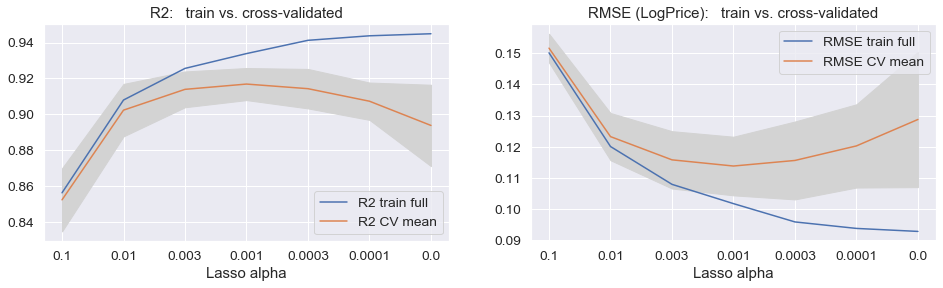

In [123]:
visualize_HP(df_report, 'Lasso alpha', list(df_report.alpha.values))

In [124]:
lasso_best_rmse = min(df_report.rmse_CV_mean)
lasso_best_alpha = df_report[df_report.rmse_CV_mean == lasso_best_rmse].alpha.values[0]
print(f'Best CV rmse: {lasso_best_rmse:.4f}\t  Best alpha: {lasso_best_alpha}')


Best CV rmse: 0.1139	  Best alpha: 0.001


In [126]:
tic=time.time()
df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)

for HP_1 in feature_groups.keys():
    X_reduced = pd.get_dummies(df.drop(feature_groups[HP_1], axis=1), drop_first=True).iloc[:len(Y), :]
    df_report.loc[df_report.shape[0]] = (['Lasso'] +
                                      [HP_1, None] + 
                                      list(model_scores('Lasso', X_reduced, Y, lasso_best_alpha)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')

area 	0.6 sec
other_continuous 	1.8 sec
counts 	3.1 sec
age 	4.4 sec
quality 	5.5 sec
basement 	6.8 sec
garage 	8.1 sec
porch 	9.5 sec
other 	10.9 sec
location 	12.0 sec
sale 	13.3 sec
house_type 	14.5 sec
land 	16.0 sec


In [127]:
df_report=df_report.sort_values(by='rmse_CV_mean', ascending=False, ignore_index=True)
df_report

,Model_name,dropped_group,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2
0,Lasso,quality,None,0.9195,0.8974,0.0114,0.1123,0.1262,0.0047,112,None
1,Lasso,area,None,0.9253,0.9055,0.0056,0.1082,0.1215,0.0069,117,None
2,Lasso,location,None,0.9232,0.9053,0.0051,0.1097,0.1215,0.0035,91,None
3,Lasso,house_type,None,0.9294,0.9124,0.0043,0.1052,0.1169,0.0051,99,None
4,Lasso,basement,None,0.9306,0.9146,0.0034,0.1043,0.1154,0.0045,107,None
5,Lasso,other,None,0.9309,0.9146,0.0050,0.1041,0.1154,0.0037,103,None
6,Lasso,age,None,0.9322,0.9152,0.0043,0.1031,0.1150,0.0044,104,None
7,Lasso,sale,None,0.9310,0.9154,0.0061,0.1040,0.1149,0.0061,106,None
8,Lasso,other_continuous,None,0.9320,0.9155,0.0046,0.1032,0.1148,0.0048,107,None
9,Lasso,counts,None,0.9322,0.9158,0.0050,0.1031,0.1146,0.0048,105,None


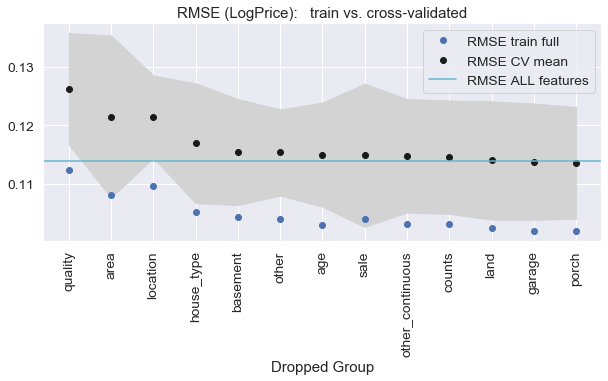

In [128]:
visualize_groups(df_report, 'Dropped Group', df_report.dropped_group, lasso_best_rmse)

In [130]:
df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)
dropped = feature_groups['porch']+feature_groups['garage']+feature_groups['land']

X_train_reduced = pd.get_dummies(df.drop(dropped, axis=1), drop_first=True).iloc[:len(Y), :]
X_test_reduced = pd.get_dummies(df.drop(dropped, axis=1), drop_first=True).iloc[len(Y):, :]

df_report.loc[df_report.shape[0]] = (['Lasso'] +
                                  ['- p,g,l', None] + 
                                  list(model_scores('Lasso', X_train_reduced, Y, lasso_best_alpha)) + 
                                  [None])
df_report

,Model_name,dropped_group,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2
0,Lasso,"- p,g,l",None,0.9323,0.9173,0.0048,0.103,0.1136,0.0055,97,None


From CV data, the best LASSO appears to exclude porch, garage, land.
However, the final performance on the test set is worse! The same tested and confirmed on Ridge.
#__Conclusion: do not pre-select the features before feeding into the model__


In [131]:
lasso_best = linear_model.Lasso(alpha=lasso_best_alpha)
# lasso_best.fit(X_train_reduced, Y)  #<- performance worse than ful features
lasso_best.fit(X_train, Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [132]:
coefs = pd.DataFrame({'coefs':lasso_best.coef_,'Positive':lasso_best.coef_ > 0}, index=X_train.columns)
print(f'LASSO dropped {sum(coefs.coefs==0)} of {coefs.shape[0]} features.  Remaining: {sum(coefs.coefs!=0)}')

LASSO dropped 136 of 248 features.  Remaining: 112


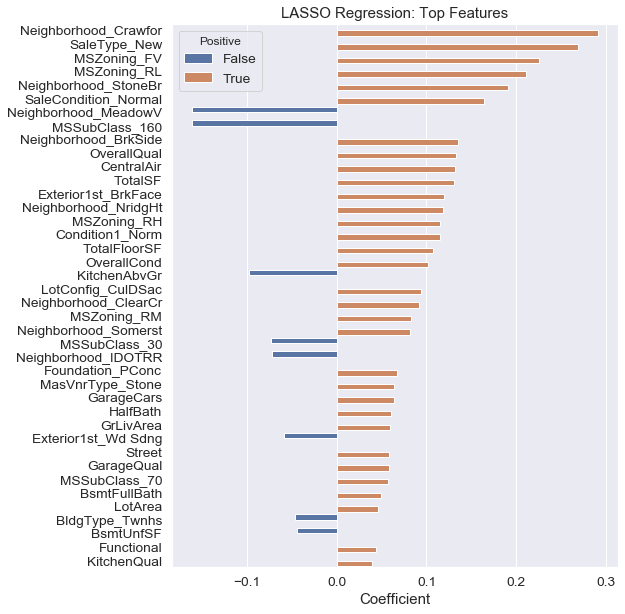

In [133]:
coefs['coefs_abs'] = np.abs(coefs.coefs)
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(40)

plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Coefficient')
plt.show()

In [134]:
# to be ensembled and/or saved as submission
y_hat_lasso = predict_prices(lasso_best, X_test)
train_predictions = predict_prices(lasso_best, X_train)

In [135]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.1f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 12,388
Empirical MAPE = 7.3%
Empirical RMSLE = 0.1018


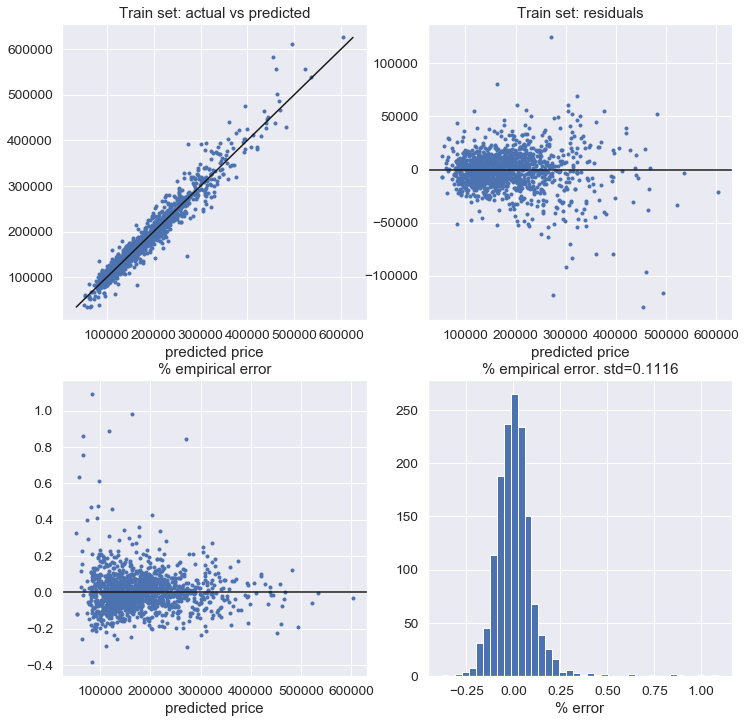

In [136]:
visualize_residuals(SalePrice, train_predictions)

## RIDGE

In [137]:
tic=time.time()
model_name  = "Ridge"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [1000, 500, 100, 50, 20, 10, 1, 0.1]:
    df_report.loc[df_report.shape[0]] = ([model_name] +
                                      [HP_1, None] + 
                                      list(model_scores(model_name, X_train, Y, HP_1)) + 
                                      [None])
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')      

1000 	0.2 sec
500 	0.3 sec
100 	0.5 sec
50 	0.7 sec
20 	0.8 sec
10 	0.9 sec
1 	1.1 sec
0.1 	1.3 sec


In [138]:
df_report

,Model_name,alpha,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2
0,Ridge,1000,None,0.9031,0.8928,0.0058,0.1232,0.1292,0.0022,243,None
1,Ridge,500,None,0.9127,0.9023,0.0050,0.1170,0.1234,0.0024,243,None
2,Ridge,100,None,0.9264,0.9123,0.0045,0.1074,0.1169,0.0037,243,None
3,Ridge,50,None,0.9305,0.9141,0.0043,0.1044,0.1157,0.0041,243,None
4,Ridge,20,None,0.9347,0.9151,0.0043,0.1012,0.1151,0.0044,243,None
5,Ridge,10,None,0.9372,0.9148,0.0044,0.0993,0.1153,0.0047,243,None
6,Ridge,1,None,0.9431,0.9094,0.0053,0.0945,0.1189,0.0063,243,None
7,Ridge,0.1,None,0.9448,0.9006,0.0070,0.0931,0.1246,0.0084,243,None


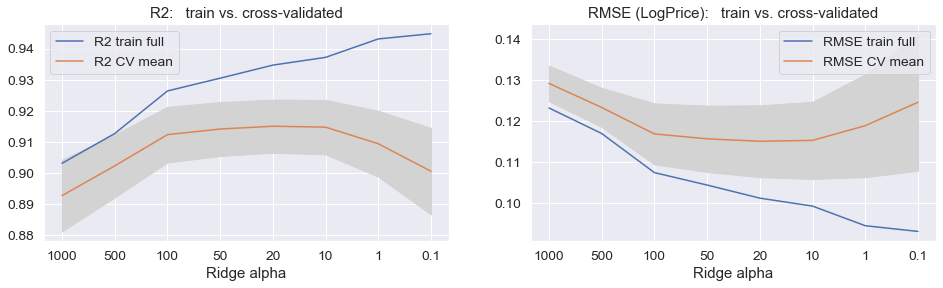

In [139]:
visualize_HP(df_report, 'Ridge alpha', list(df_report.alpha.values))

In [140]:
ridge_best_rmse = min(df_report.rmse_CV_mean)
ridge_best_alpha = df_report[df_report.rmse_CV_mean == ridge_best_rmse].alpha.values[0]
print(f'Best CV rmse: {ridge_best_rmse:.4f}\t  Best alpha: {ridge_best_alpha}')


Best CV rmse: 0.1151	  Best alpha: 20


In [141]:
ridge_best = linear_model.Ridge(alpha=ridge_best_alpha)
ridge_best.fit(X_train, Y)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

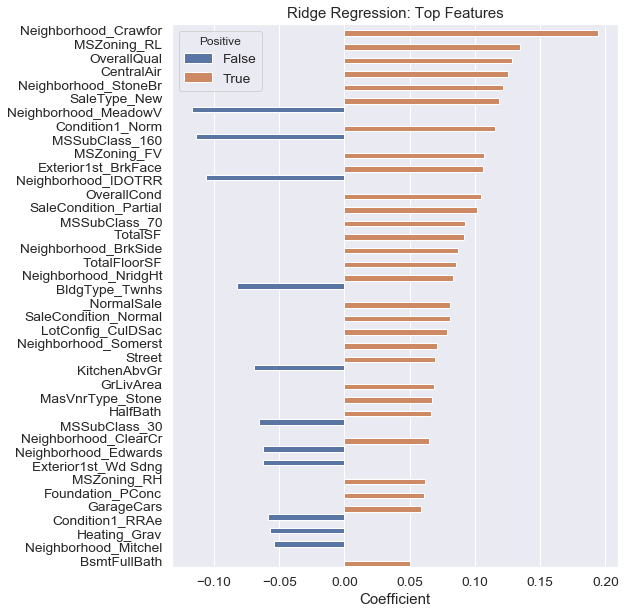

In [142]:
coefs = pd.DataFrame({'coefs':ridge_best.coef_.flatten(),
                      'Positive':ridge_best.coef_.flatten() > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(40)

plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('Ridge Regression: Top Features')
plt.xlabel('Coefficient')
plt.show()


In [143]:
# to be ensembled and/or saved as submission
y_hat_ridge = predict_prices(ridge_best, X_test)
train_predictions = predict_prices(ridge_best, X_train)

y_hat_ridge, train_predictions = np.squeeze(y_hat_ridge), np.squeeze(train_predictions)

In [144]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.1f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 12,291
Empirical MAPE = 7.3%
Empirical RMSLE = 0.1012


In [145]:
#visualize_residuals(SalePrice, train_predictions)

## Elastic Net

In [146]:
tic=time.time()
model_name  = "net"   #Rob:adding model name so we can simple compare a table of model performance metrics

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'alpha', 'HP_2': 'rho', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [0.1, 0.01, 0.001, 0.0005]:
    for HP_2 in [0.1, 0.5, 1]:
        df_report.loc[df_report.shape[0]] = ([model_name] +
                                          [HP_1, HP_2] + 
                                          list(model_scores(model_name, X_train, Y, HP_1, HP_2)) + 
                                          [None])
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')      


0.1 	0.1 	0.2 sec
0.1 	0.5 	0.4 sec
0.1 	1 	0.6 sec
0.01 	0.1 	1.4 sec
0.01 	0.5 	2.0 sec
0.01 	1 	2.4 sec
0.001 	0.1 	4.1 sec
0.001 	0.5 	5.5 sec
0.001 	1 	7.0 sec
0.0005 	0.1 	8.6 sec
0.0005 	0.5 	10.4 sec
0.0005 	1 	12.0 sec


In [147]:
df_report

,Model_name,alpha,rho,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2
0,net,0.1000,0.1,0.9059,0.9007,0.0068,0.1214,0.1243,0.0031,39,None
1,net,0.1000,0.5,0.8844,0.8796,0.0068,0.1346,0.1369,0.0021,17,None
2,net,0.1000,1.0,0.8563,0.8523,0.0088,0.1501,0.1516,0.0023,11,None
3,net,0.0100,0.1,0.9311,0.9163,0.0044,0.1039,0.1142,0.0045,121,None
4,net,0.0100,0.5,0.9180,0.9091,0.0056,0.1134,0.1190,0.0045,55,None
5,net,0.0100,1.0,0.9080,0.9023,0.0073,0.1201,0.1233,0.0038,34,None
6,net,0.0010,0.1,0.9415,0.9122,0.0050,0.0958,0.1170,0.0060,198,None
7,net,0.0010,0.5,0.9379,0.9163,0.0051,0.0987,0.1143,0.0053,145,None
8,net,0.0010,1.0,0.9339,0.9169,0.0045,0.1018,0.1139,0.0047,112,None
9,net,0.0005,0.1,0.9431,0.9092,0.0051,0.0944,0.1190,0.0064,221,None


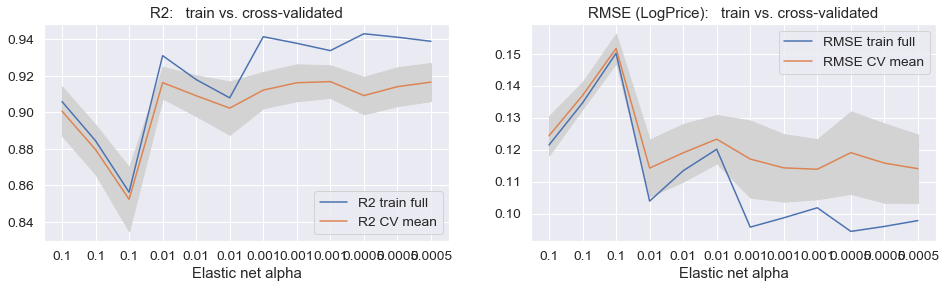

In [148]:
visualize_HP(df_report, 'Elastic net alpha', list(df_report.alpha.values))

In [149]:
# Conclusion: The best performance is when Elastic net rho=1, i.e. pure LASSO

## XGBoost

In [150]:
from xgboost import XGBRegressor

In [151]:
def scores_xgboost(X_train, Y, n_estimators=3000, learning_rate=0.01):

    model = XGBRegressor(learning_rate=learning_rate,   # >>> 0.01
                       n_estimators=n_estimators,   # >>> 3000
                       max_depth=3,          # >>> 3
                       min_child_weight=3,   # another regularization, default 1 >>> 3
                       reg_alpha=0.05,        # L1 reg on weights   >>> 0.05
                       reg_lambda=2,         # >>> 2
                       gamma=0,       # min.similarity threshold 
                       subsample=0.5,         # cross-validation capability   >>> 0.5 not important
                       colsample_bytree=0.25,  # % of features used by tree  >>> 0.25
                       objective= 'reg:squarederror',
                       nthread=-1,            # may help on GPU
                       seed=2020,
                       verbosity=0
                       )
    
    model.fit(X_train, Y)
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std())

In [152]:
tic=time.time()
model_name  = "XGBoost"  

df_report = df_CV.copy()
df_report.rename(columns={'HP_1': 'n_estimators', 'HP_2': 'learning_rate'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [3000]:
    for HP_2 in [0.008,0.01,0.012]:
        df_report.loc[df_report.shape[0]] = ([model_name] +
                                             [HP_1, HP_2] +
                                            list(scores_xgboost(X_train, Y, HP_1, HP_2)) + 
                                             [None, None])
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')
     

3000 	0.008 	59.6 sec
3000 	0.01 	116.5 sec
3000 	0.012 	173.7 sec


In [153]:
df_report

,Model_name,n_estimators,learning_rate,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,OUT_1,OUT_2
0,XGBoost,3000,0.008,0.9702,0.9184,0.0042,0.0684,0.1129,0.0055,None,None
1,XGBoost,3000,0.010,0.9749,0.9188,0.0045,0.0627,0.1126,0.0058,None,None
2,XGBoost,3000,0.012,0.9785,0.9183,0.0047,0.0581,0.1129,0.0059,None,None


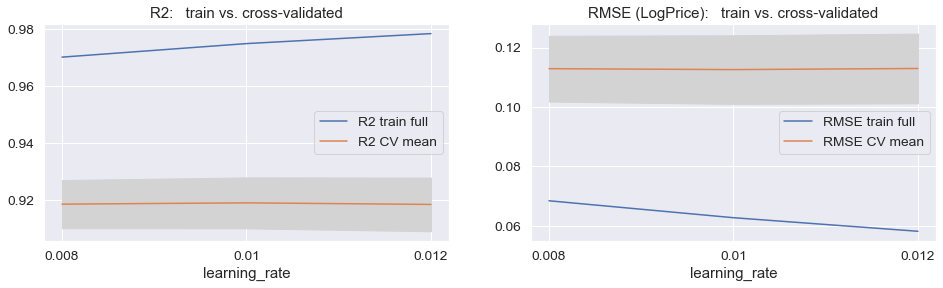

In [154]:
visualize_HP(df_report, 'learning_rate', list(df_report.learning_rate.values))

In [168]:
XGBoost_best =  XGBRegressor(learning_rate=0.01, n_estimators=3000,
                max_depth=3, min_child_weight=3, reg_alpha=0.05, reg_lambda=2, gamma=0,  subsample=0.5,
                colsample_bytree=0.25, objective= 'reg:squarederror', nthread=-1, seed=2020, verbosity=0)
XGBoost_best.fit(X_train, Y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.25, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=2020, reg_alpha=0.05,
             reg_lambda=2, scale_pos_weight=1, seed=2020, subsample=0.5,
             tree_method=None, validate_parameters=False, verbosity=0)

In [166]:
# to be ensembled and/or saved as submission
y_hat_XGBoost = predict_prices(XGBoost_best, X_test)
train_predictions = predict_prices(XGBoost_best, X_train)

In [165]:
print(f'Empirical MAE = {mae(SalePrice, train_predictions):,.0f}')
print(f'Empirical MAPE = {100*mape(SalePrice, train_predictions):.1f}%')
print(f'Empirical RMSLE = {rmsle(SalePrice, train_predictions):.4f}')

Empirical MAE = 8,326
Empirical MAPE = 4.9%
Empirical RMSLE = 0.0675


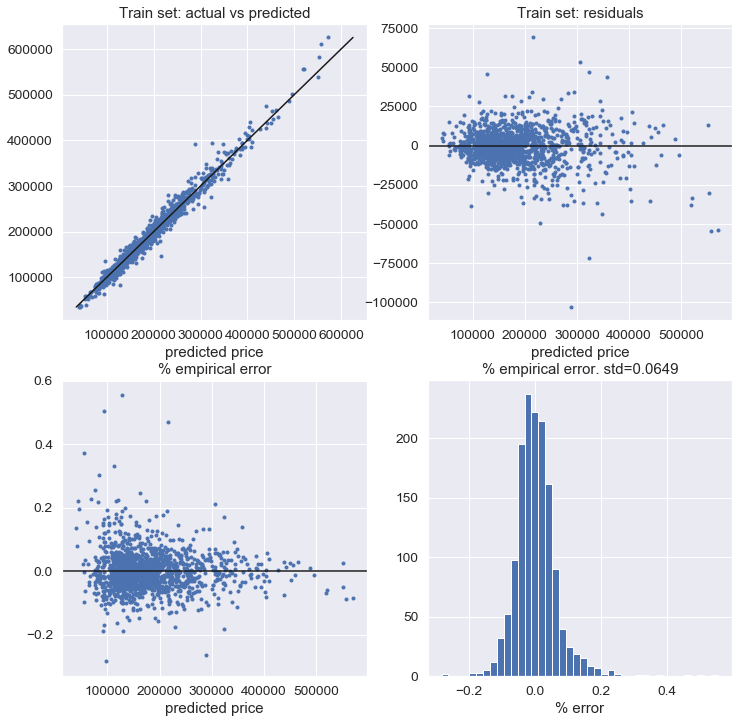

In [158]:
visualize_residuals(SalePrice, train_predictions)

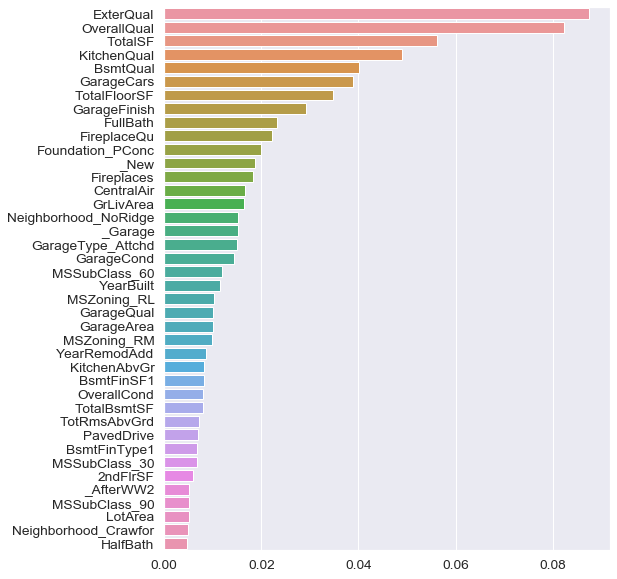

In [159]:
# XGBoost feature importance
fi = pd.Series(XGBoost_best.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False, inplace=True)

top_features = 40

plt.figure(figsize=(8,10))
sns.barplot( fi.values[:top_features], fi.index[:top_features], orient='h')
plt.show()

# Submissions

In [160]:
def save_submission(y_hat, filename_prefix):
    submission_df = pd.DataFrame(data={'Id':test.Id, 'SalePrice':y_hat})
    submission_df.to_csv(f'./submissions/{filename_prefix}_{round(time.time())}.csv', index=False)


In [161]:
save = False

if save:
    save_submission(y_hat_lasso, 'lasso')
    # 0.12091

    save_submission(y_hat_ridge, 'ridge')
    # 0.12048

    save_submission(y_hat_XGBoost, 'xgboost')
    # 0.12021

    save_submission( (y_hat_lasso+y_hat_ridge)/2, 'lasso_ridge')
    # 0.12049

    save_submission( (y_hat_lasso+y_hat_XGBoost)/2, 'lasso_xgboost')
    # 0.11750

    save_submission( (y_hat_XGBoost+y_hat_ridge)/2, 'ridge_xgboost')
    # 0.11720

    save_submission( (y_hat_lasso+y_hat_ridge+y_hat_XGBoost)/3, 'all3')
    # 0.11769

In [162]:
# save_submission(y_hat_lasso, 'lasso_reduced')

In [167]:
save_submission(y_hat_XGBoost, '2500_xgboost')